In [1]:

import dyna_env_drifttype
import numpy as np
import pandas as pd
import ast
from collections import deque
from dyna_env_drifttype import TaskEnv_driftype
import agent_noA
from agent_noA import OptimalPolicyAgent,RandomAgent,Q_learning_Agent,DQNAgent
from agent_noA import PPOAgent,MetaDQNAgent
import warnings
warnings.filterwarnings('ignore')

/Users/veetin/Desktop/drifttest_pa/main/dyna_env_drifttype.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错


run different agent with different transition probability drift 
at the end of the file there is MDP visualization

In [39]:
env = TaskEnv_driftype()
env.observation_space

va  \
contact beeindigd/weggegaan             {'sib': 0.016039481801357187, 'pp': 0.14497223...   
client toegesproken/gesprek met client  {'pp': 0.13498952409458245, 'Tau': 0.574977551...   
geen                                    {'Tau': 0.5918367346938775, 'va': 0.1836734693...   
client afgeleid                         {'pp': 0.17118402282453637, 'Tau': 0.514978601...   
naar andere kamer/ruimte gestuurd       {'Tau': 0.5496974935177182, 'va': 0.2584269662...   
met kracht tegen- of vastgehouden       {'pp': 0.21645021645021645, 'va': 0.1688311688...   
afzondering (deur op slot)              {'pp': 0.4444444444444444, 'sib': 0.0085470085...   

                                                                                      sib  \
contact beeindigd/weggegaan             {'pp': 0.1927710843373494, 'sib': 0.1566265060...   
client toegesproken/gesprek met client  {'Tau': 0.5019206145966709, 'pp': 0.1574903969...   
geen                                    {'va': 0.045512010113780026, 'Tau': 0.56005056...   
client afgeleid                         {'Tau': 0.5410447761194029, 'pp': 0.1604477611...   
naar andere kamer/ruimte gestuurd       {'Tau': 0.5540540540540541, 'pp': 0.2297297297...   
met kracht tegen- of vastgehouden       {'Tau': 0.3983050847457627, 'pp': 0.2330508474...   
afzondering (deur op slot)              {'pp': 0.21052631578947367, 'Tau': 0.526315789...   

                                                                                       pp  \
contact beeindigd/weggegaan             {'pp': 0.3647011308562197, 'Tau': 0.4810177705...   
client toegesproken/gesprek met client  {'pp': 0.34570637119113573, 'Tau': 0.516897506...   
geen                                    {'Tau': 0.42410714285714285, 'pp': 0.40625, 'v...   
client afgeleid                         {'Tau': 0.46188850967007966, 'po': 0.024459613...   
naar andere kamer/ruimte gestuurd       {'pp': 0.36347358997314233, 'Tau': 0.500447627...   
met kracht tegen- of vastgehouden       {'Tau': 0.44761199555720105, 'pp': 0.421695668...   
afzondering (deur op slot)              {'va': 0.11392405063291139, 'pp': 0.3971518987...   

                                                                                       po  
contact beeindigd/weggegaan             {'pp': 0.1829787234042553, 'va': 0.14893617021...  
client toegesproken/gesprek met client  {'Tau': 0.5195154777927322, 'pp': 0.2126514131...  
geen                                    {'Tau': 0.5189873417721519, 'sib': 0.075949367...  
client afgeleid                         {'Tau': 0.4915254237288136, 'va': 0.0720338983...  
naar andere kamer/ruimte gestuurd       {'Tau': 0.4945054945054945, 'pp': 0.1978021978...  
met kracht tegen- of vastgehouden       {'Tau': 0.4925373134328358, 'pp': 0.2835820895...  
afzondering (deur op slot)              {'pp': 0.4470588235294118, 'va': 0.14117647058...

In [3]:
import os
import csv
from itertools import product


# 保存结果到 CSV 文件
def save_to_csv(data, filename):
    os.makedirs("driftdistypeQsud", exist_ok=True)
    path = os.path.join("driftdistypeQsud", filename)
    with open(path, mode="w", newline="") as file:
        writer = csv.writer(file)
        if isinstance(data, dict):
            writer.writerow(["State", "Action"])
            for k, v in data.items():
                writer.writerow([k, v])
        elif isinstance(data, list):
            writer.writerow(data)
        else:
            raise ValueError("Unsupported data format for saving.")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#修改 生成有average 的，和没有average的两个图
"""
def compare_agents_plot(reward_lists, labels):
    
    reward_lists: list of 1D lists or arrays of episodic rewards for each agent
    labels: list of labels for each agent (e.g., ["Random", "Q-Learning", "Value Iteration", "Policy Iteration"])
    colors: list of colors for plotting each agent
    
    def smooth(arr):
        arr = np.array(arr)
        return pd.Series(arr).rolling(window=30).mean()
        

    x = np.arange(1, 2001)  # 100 segments

    plt.figure(figsize=(12, 6))
    colors = cm.viridis(np.linspace(0, 1, len(reward_lists)))

    for rewards, label, color in zip(reward_lists, labels, colors):
        y = smooth(rewards)
        #y = rewards
        plt.plot(x, y, label=label, color = color)
    
    plt.axvline(x=500, color='red', linestyle='--', label='drift happens')
    #plt.axvline(x=700, color='red', linestyle='--', label='gradual drift finish')
    plt.title("Comparison of Agent Performance 20 window size")
    plt.xlabel("episodes)")
    plt.ylabel("Average Episodic Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
"""

'\ndef compare_agents_plot(reward_lists, labels):\n    \n    reward_lists: list of 1D lists or arrays of episodic rewards for each agent\n    labels: list of labels for each agent (e.g., ["Random", "Q-Learning", "Value Iteration", "Policy Iteration"])\n    colors: list of colors for plotting each agent\n    \n    def smooth(arr):\n        arr = np.array(arr)\n        return pd.Series(arr).rolling(window=30).mean()\n        \n\n    x = np.arange(1, 2001)  # 100 segments\n\n    plt.figure(figsize=(12, 6))\n    colors = cm.viridis(np.linspace(0, 1, len(reward_lists)))\n\n    for rewards, label, color in zip(reward_lists, labels, colors):\n        y = smooth(rewards)\n        #y = rewards\n        plt.plot(x, y, label=label, color = color)\n    \n    plt.axvline(x=500, color=\'red\', linestyle=\'--\', label=\'drift happens\')\n    #plt.axvline(x=700, color=\'red\', linestyle=\'--\', label=\'gradual drift finish\')\n    plt.title("Comparison of Agent Performance 20 window size")\n    plt.xl

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def compare_agents_plot(reward_lists, labels,type):
    """
    reward_lists: list of 1D lists or arrays of episodic rewards for each agent
    labels: list of labels for each agent (e.g., ["Random", "Q-Learning", "Value Iteration", "Policy Iteration"])
    """
    def smooth(arr):
        arr = np.array(arr)
        return pd.Series(arr).rolling(window=40).mean()
    
   # x = np.arange(1, 2101)  # 100 segments
    x = np.arange(1, 2101) 
    colors = cm.plasma(np.linspace(0, 0.9, len(reward_lists)))
    #colors = cm.viridis(np.linspace(0, 1, len(reward_lists)))
    
    # 创建两个子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))  # 总宽度24以容纳两个12宽的图
    
        # 第二个图：不使用smooth
    for rewards, label, color in zip(reward_lists, labels, colors):
        y = rewards
        ax1.plot(x, y, label=label, color=color, alpha=0.7)  # 添加透明度使原始数据更易读
    
    ax1.axvline(x=500, color='red', linestyle='--', label='gradual drift happens')
    ax2.axvline(x=1400, color='red', linestyle='--', label='gradual drift ends')
    if type == 'reward':
        ax1.set_title("Compare different agent performance by reward (Raw Data)", fontsize=16)
        ax1.set_xlabel("Episodes", fontsize=14)
        ax1.set_ylabel("Episodic Reward", fontsize=14)
    elif type =='length':
        ax1.set_title("Compare different agent performance by step length (Raw Data)", fontsize=16)
        ax1.set_xlabel("Episodes", fontsize=14)
        ax1.set_ylabel("Episodic step length", fontsize=14)

    ax1.legend(fontsize=14)
    ax1.grid(True)
    ax1.tick_params(labelsize=14)

    
    # 第一个图：使用smooth
    for rewards, label, color in zip(reward_lists, labels, colors):
        y = smooth(rewards)
        ax2.plot(x, y, label=label, color=color)
    
    ax2.axvline(x=500, color='red', linestyle='--', label=' drift happens')
    if type == 'reward':
        ax2.set_title("Compare different agent performance by reward (Smoothed - 30 window size)", fontsize=16)
        ax2.set_xlabel("Episodes", fontsize=14)
        ax2.set_ylabel("Average Episodic Reward", fontsize=14)
    elif type =='length':
        ax2.set_title("Compare different agent performance by step length (Smoothed - 30 window size)", fontsize=16)
        ax2.set_xlabel("Episodes", fontsize=14)
        ax2.set_ylabel("Average Episodic Step Length", fontsize=14)

    ax2.legend(fontsize=14)
    ax2.grid(True)
    ax2.tick_params(labelsize=14)
    
    
    plt.tight_layout()
    plt.show()

In [67]:
#run agent with already generated drifted env
def run_agent_apply_drift(agent_type,apply_drift=True,add_actions=0, change_at_states=['pp'], drift_dis_type=None,intensity =None,drift_type=None):
    #initial agent

    drift_dis_type=drift_dis_type
    intensity =intensity
    drift_type=drift_type

    env = TaskEnv_driftype()
    state_dim = len(env.states) 
    action_dim = len(env.motions)  
    state_to_index = {state: idx for idx, state in enumerate(env.states)}
    agent = None
    
    
    match agent_type:
        case 'Q':
            agent = Q_learning_Agent(env)
        case 'DQN':
            agent = DQNAgent(state_dim,action_dim)
        case 'PPO':
            agent = PPOAgent(state_dim,action_dim)
        case 'Opt':
            agent = OptimalPolicyAgent(env)
            agent.value_iteration()
            for state, action in agent.policy.items():
                print(f"In state {state}, take action: {action}")
        case 'R':
            agent = RandomAgent(env)
        case 'MetaDQN':
            agent = MetaDQNAgent(env)
  
    
    episode_rewards = []
    episode_lengths = []
    episodic_trojactory = []
    information = {}


    total_episodes = 2100
    drift_episode = 700 #在第700个episode触发drift

    update_interval=10  #for PPO

    suffix = f"changestate{change_at_states}_{agent_type}"
    for episode in range(total_episodes):
        steps = 0
        # 应用drift
        if apply_drift and episode == drift_episode:             
            env.set_flag()

            #env.drift(add_actions=0, change_at_states=['pp'], drift_dis_type = drift_dis_type,intensity = intensity,drift_type=drift_type)
            
            env.drift_type=drift_type
            if drift_dis_type =='random':
                frequencies = pd.read_csv("./agent_result/agent_result\changestate['pp']_Q_MDP.csv", index_col=0)
            if drift_dis_type =='similar':
                frequencies = pd.read_csv("./agent_result/pp_similar_sud.csv", index_col=0)
            if drift_dis_type =='inverse':
                frequencies = pd.read_csv("./agent_result/pp_inverse_sud.csv", index_col=0)
           
            for label in frequencies:
                for action in env.motions:
                    frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错
        
            if drift_type=='gradual':
                env.observation_space_drift = frequencies  # 仅改变转移概率
            else:
                env.observation_space = frequencies
        
      
            
            print(f"Drift applied at episode {episode}")
            if agent_type =='Opt':
                print('reset the optimal oplicy for policy iteration model.')
                agent.value_iteration()


        if apply_drift and drift_type == 'gradual' and episode == drift_episode+700:
                #swap to another distribution after 100 episode
            env.drift_swap = True
            env.observation_space = env.observation_space_drift.copy(deep=True)
            if agent_type =='Opt':
                print('reset the optimal oplicy for policy iteration model.')
                agent.value_iteration()
                

        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            if agent_type == 'Q':
               # print(agent)
                action = agent.select_action(state)
            elif agent_type in['R','Opt']:
                action = agent.act(state)
            elif agent_type =='DQN':
                action = agent.get_action(state, state_to_index)
            elif agent_type =='PPO':
                action, log_prob, value = agent.select_action(state)
            elif agent_type =='MetaDQN':
                action = agent.act(state)
            
            
            next_state, reward, done, info = env.step(action)
            
            if info != []:
                key = ''.join(str(x) for x in info)
                if key not in information:
                    information[key] = 1
                else:
                    information[key] += 1
            if agent_type == 'Q':
                #print(agentt
                agent.learn(state, action, next_state, reward, done)
            elif agent_type== 'DQN':
                agent.remember(state, action, reward, next_state, done)
                agent.train(batch_size=1, state_to_index=state_to_index)
            elif agent_type =='PPO':
                agent.store_transition(state, action, reward, log_prob, value, done)
            elif agent_type =='MetaDQN':
                agent.remember(state, action, reward, next_state, done)
                # Standard replay
                loss = agent.replay()
                if loss:
                    agent.loss_history.append(loss)
                # Meta-update less frequently
                if episode % 10 == 0:
                    agent.meta_update()
                            # Update target network periodically
                if episode% agent.update_target_every == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                # Decay epsilon
                if agent.epsilon > agent.epsilon_min:
                    agent.epsilon *= agent.epsilon_decay
                  
            state = next_state
            episode_reward += reward
            steps +=1
        if agent_type=='PPO':
            if (episode + 1) % update_interval == 0:
                agent.update()
                agent.clear_memory()
            
        episodic_trojactory.append(info)
        episode_lengths.append(steps)
        episode_rewards.append(episode_reward)
    
    return episode_rewards, episode_lengths,information,episodic_trojactory



def run_agent_avg(agent_type, apply_drift=True, add_actions=0, 
                  change_at_states=['pp'], 
                  drift_dis_type=None, intensity=None, drift_type=None):
    
    num_runs = 5
    all_rewards = []
    all_lengths = []
    info_first_run = None

    for run in range(num_runs):
        rewards, lengths, info, trojactory= run_agent_apply_drift(
            agent_type=agent_type,
            apply_drift=apply_drift,
            add_actions=add_actions,
            change_at_states=change_at_states,
            drift_dis_type=drift_dis_type,
            intensity=intensity,
            drift_type=drift_type
        )
        all_rewards.append(rewards)
        all_lengths.append(lengths)
        if run == 0:
            info_first_run = info
            trojactory_first_run = trojactory

    # Convert to numpy arrays for averaging
    all_rewards = np.array(all_rewards)
    all_lengths = np.array(all_lengths)

    avg_rewards = np.mean(all_rewards, axis=0).tolist()
    avg_lengths = np.mean(all_lengths, axis=0).tolist()

    #sd_rewards = np.std(all_rewards, axis=0).tolist()
    #sd_lengths = np.std(all_lengths, axis=0).tolist()

    return avg_rewards, avg_lengths#, #sd_rewards, sd_lengths #info_first_run,trojactory_first_run

In [68]:
#os.makedirs("stdRewLen", exist_ok=True)


In [69]:
from typing import List
import numpy as np

def reward_to_score(r: float, r_opt: float, r_min: float) -> float:
    """归一化 reward 为正向 score（越大越好）"""
    return (r - r_min) / (r_opt - r_min)

def check_recovery_negative_rewards(
    opt_pre_drift: List[float],
    agent_pre_drift: List[float],
    opt_post_drift: List[float],
    agent_post_drift: List[float],
    window_size: int = 50,
    consecutive_required: int = 200
):
    # Step 1: 计算 pre-drift 和 post-drift 的平均 reward
    r_opt_pre = np.mean(opt_pre_drift)
    r_agent_pre = np.mean(agent_pre_drift)
    r_opt_post = np.mean(opt_post_drift)
    r_agent_post = np.mean(agent_post_drift)


    r_opt_pre_sd = np.std(opt_pre_drift)
    r_agent_pre_sd = np.std(agent_pre_drift)
    r_opt_post_sd = np.std(opt_post_drift)
    r_agent_post_sd = np.std(agent_post_drift)

    # Step 2: 找到合理的 reward 下界，用于归一化
    r_min = min(min(agent_pre_drift), min(opt_pre_drift),
                min(agent_post_drift[-100:]), min(opt_post_drift)) - 1e-6  # 避免除以0

    print("the value compute stander, agent post, opt post, agent pre, opt prem, r min:",r_agent_post, r_opt_post,r_agent_pre, r_opt_pre, r_min)
    print("the value compute std, agent post std, opt post std, agent pre std, opt pre std,:",r_agent_post_sd, r_opt_post_sd,r_agent_pre_sd, r_opt_pre_sd)
    # Step 3: 计算 pre-drift agent 的标准表现分数 alpha
    #score_opt_pre = reward_to_score(r_opt_pre, r_opt_pre, r_min)  # 始终为1
    score_agent_pre = reward_to_score(r_agent_pre, r_opt_pre, r_min)
    alpha = score_agent_pre
    print('the alpha value:', alpha)
    # Step 4: 设定恢复标准（90% of pre-drift performance）
    recovery_threshold = 0.95 * alpha

    # Step 5: 对 post-drift agent 的 reward 做 rolling window
    recovery_streak = 0
    windows_rolled = 0
    recovered = False

    for i in range(len(agent_post_drift) - window_size + 1):
        window = agent_post_drift[i : i + window_size]
        window_mean = np.mean(window)
        window_score = reward_to_score(window_mean, r_opt_post, r_min)
        windows_rolled += 1

        if window_score >= recovery_threshold:
            recovery_streak += 1
            if recovery_streak == consecutive_required:
                recovered = True
                break
        else:
            recovery_streak = 0

    result = (
        "========== RECOVERY EVALUATION ==========\n"
        f'r min: {r_min:.2f}\n'
        f"Agent pre-drift average reward: {r_agent_pre:.2f}\n"
        f"Optimal pre-drift average reward: {r_opt_pre:.2f}\n"
        f"Agent post-drift average reward: {r_agent_post:.2f}\n"
        f"Optimal post-drift average reward: {r_opt_post:.2f}\n"
        f"Recovery standard (90% of relative performance): {recovery_threshold:.2f}\n"
        f"Recovered: {recovered}\n"
    )
    
    # 根据是否恢复添加额外信息
    if recovered:
        result += f"Recovery achieved in {windows_rolled} windows\n"
    else:
        result += f"Recovery not achieved in {windows_rolled} windows\n"
    
    return result


In [63]:
list1 = [1,2,3,4]
np.std(list1)


1.118033988749895

In [64]:

def test_all_agents(change_at_state, drift_dis_type, drift_type):
    agent_types = ['R', 'Q', 'DQN', 'PPO','MetaDQN','Opt']
    compare_rewards = []
    compare_lengths = []
    std_rew = []
    std_len = []
#for compute if the agent recover
    rew_before_drift = [] #per agent
    rewlist_drift = []
    fullrewlist_drift=[]

    for agent_type in agent_types:
        print(f"Running agent_type={agent_type}")
        rewards, lengths = run_agent_avg(agent_type=agent_type, apply_drift=True,change_at_states=change_at_state,
                                                          drift_dis_type=drift_dis_type,drift_type=drift_type)
        compare_rewards.append(rewards)
        compare_lengths.append(lengths)
        std_rew.append(np.std(rewards))
        std_len.append(np.std(lengths))
        
        
        rew_before_drift.append(rewards[400:500])
        rewlist_drift.append(rewards[:-100])
        fullrewlist_drift.append(rewards[500:])
        
    compare_agents_plot(compare_rewards, agent_types,'reward')
    compare_agents_plot(compare_lengths, agent_types,'length')

    suffix = f"{drift_dis_type}_{drift_type}"
    #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")

    with open(f"{suffix}_output.txt", "a") as f: 
        for i in range(1,6):
            print('analysis for agent type:',agent_types[i])
            print('std of reward', std_rew[i])
            print('std of len', std_len[i])
            f.write(f'analysis for agent type: {agent_types[i]}\n')
            f.write(f'std of reward: {std_rew[i]}\n')
            f.write(f'std of len: {std_len[i]}\n')
        
        # 调用函数并写入结果
            recovery_result = check_recovery_negative_rewards(
                rew_before_drift[-1],
                rew_before_drift[i],
                rewlist_drift[-1],
                fullrewlist_drift[i]
            )
            f.write(f'recovery check result: {recovery_result}\n\n')  # 加空行分隔不同 agent 的结果

    


"""
        suffix = f"{agent_type}_[pp]_None"
        #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")
        save_to_csv(rewards, f"{suffix}_rewards.csv")
        save_to_csv(lengths, f"{suffix}_lengths.csv")
        save_to_csv([[k, v] for k, v in info.items()], f"{suffix}_info.csv")
               
        df = pd.DataFrame(trojactory)
        df.to_csv(f"./diffagent_res_gradual_random/{suffix}_trojactory.csv", index=True, header=True) 
  
    df = pd.DataFrame([std_rewds, std_lens])
    df.index = ['std_rews', 'std_lens']
    df.to_csv(f"./stdRewLen/stdinverse.csv", index=True, header=True)"""


    

'\n        suffix = f"{agent_type}_[pp]_None"\n        #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")\n        save_to_csv(rewards, f"{suffix}_rewards.csv")\n        save_to_csv(lengths, f"{suffix}_lengths.csv")\n        save_to_csv([[k, v] for k, v in info.items()], f"{suffix}_info.csv")\n               \n        df = pd.DataFrame(trojactory)\n        df.to_csv(f"./diffagent_res_gradual_random/{suffix}_trojactory.csv", index=True, header=True) \n  \n    df = pd.DataFrame([std_rewds, std_lens])\n    df.index = [\'std_rews\', \'std_lens\']\n    df.to_csv(f"./stdRewLen/stdinverse.csv", index=True, header=True)'

Running agent_type=R
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=Q
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=DQN
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=PPO
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=MetaDQN
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=Opt
In state va, take action: client toegesproken/gesprek met client
In state sib, take action: geen
In state pp, take action: client toegesp

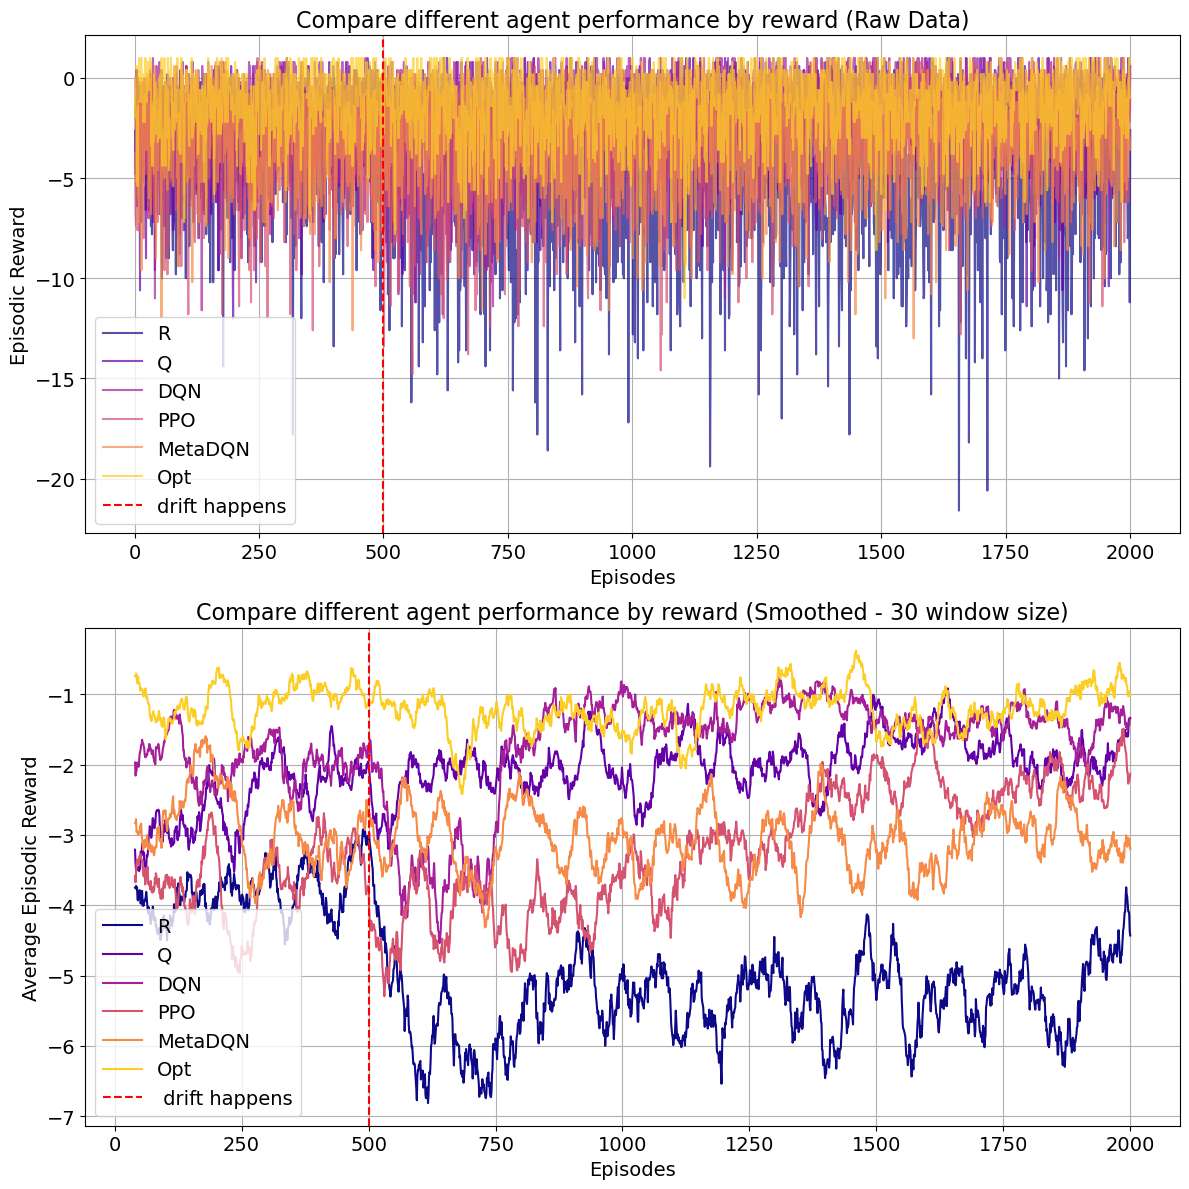

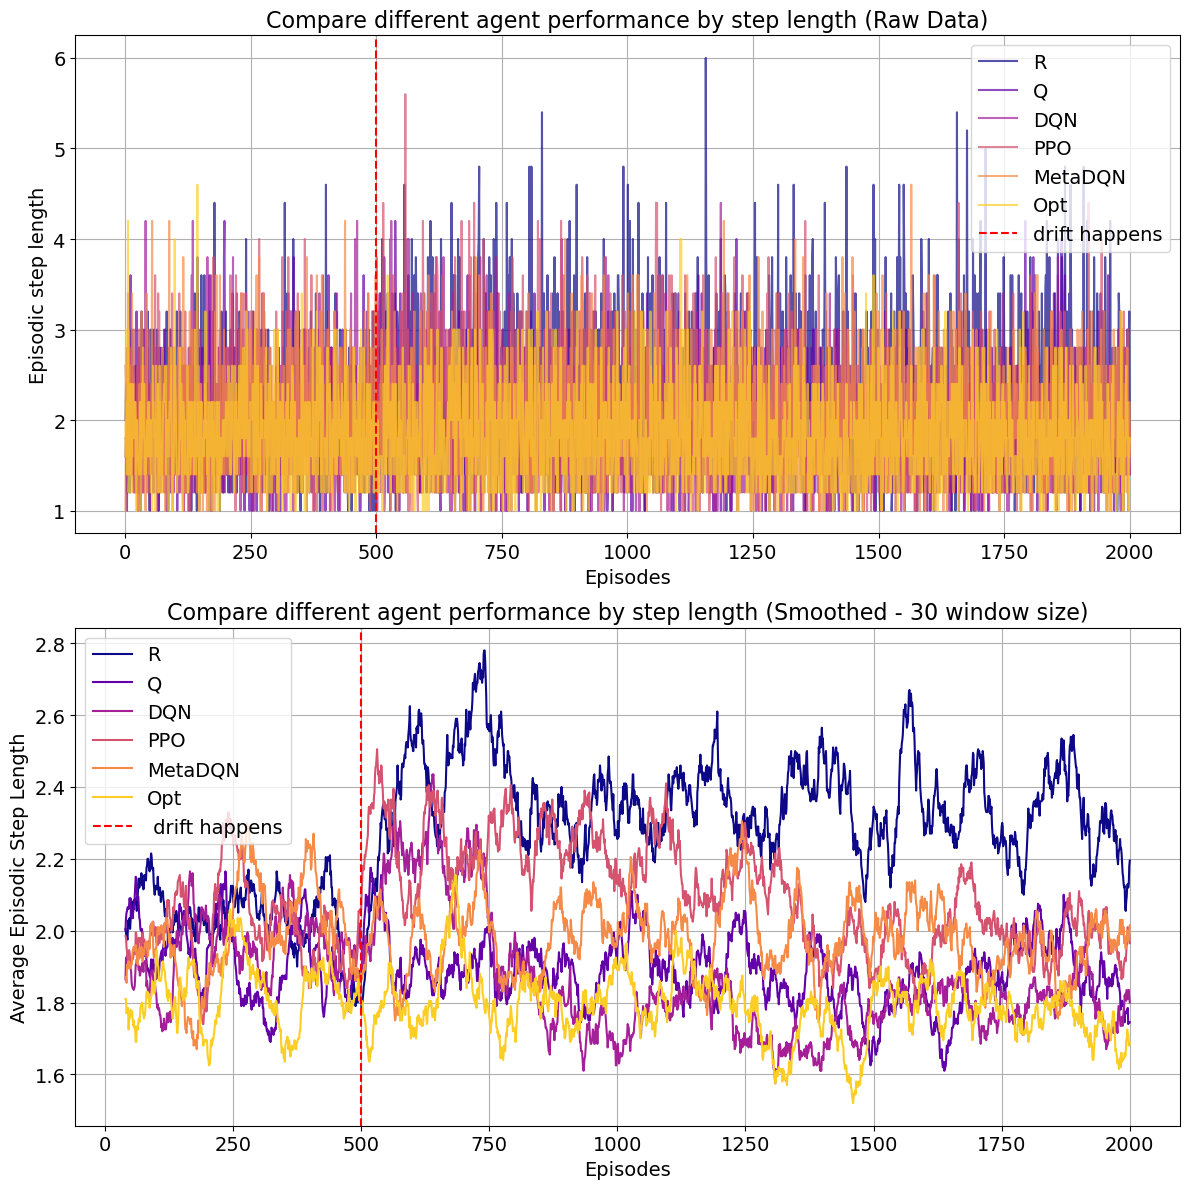

analysis for agent type: Q
std of reward 2.121936389244503
std of len 0.5571139919262484
the value compute stander, agent post, opt post, agent pre, opt prem, r min: -1.94 -1.2066315789473683 -2.1559999999999997 -1.02 -11.000001
the value compute std, agent post std, opt post std, agent pre std, opt pre std,: 2.0604659667172376 1.7123754571854828 2.027329277645839 1.5769590990257165
the alpha value: 0.8861723560949542
analysis for agent type: DQN
std of reward 2.206855174224172
std of len 0.5867264780116882
the value compute stander, agent post, opt post, agent pre, opt prem, r min: -1.6761333333333333 -1.2066315789473683 -1.8820000000000001 -1.02 -11.000001
the value compute std, agent post std, opt post std, agent pre std, opt pre std,: 2.2540963560199065 1.7123754571854828 1.8286814922232904 1.5769590990257165
the alpha value: 0.9136272631636009
analysis for agent type: PPO
std of reward 2.671832462936252
std of len 0.6538004588557582
the value compute stander, agent post, opt post,

In [38]:
test_all_agents(change_at_state=['pp'], drift_dis_type='random', drift_type='sudden') #用的保存下来的MDP跑的

Running agent_type=R
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=Q
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=DQN
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=PPO
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=MetaDQN
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=Opt
In state va, take action: client toegesproken/gesprek met client
In state sib, take action: geen
In state pp, take action: client toegesp

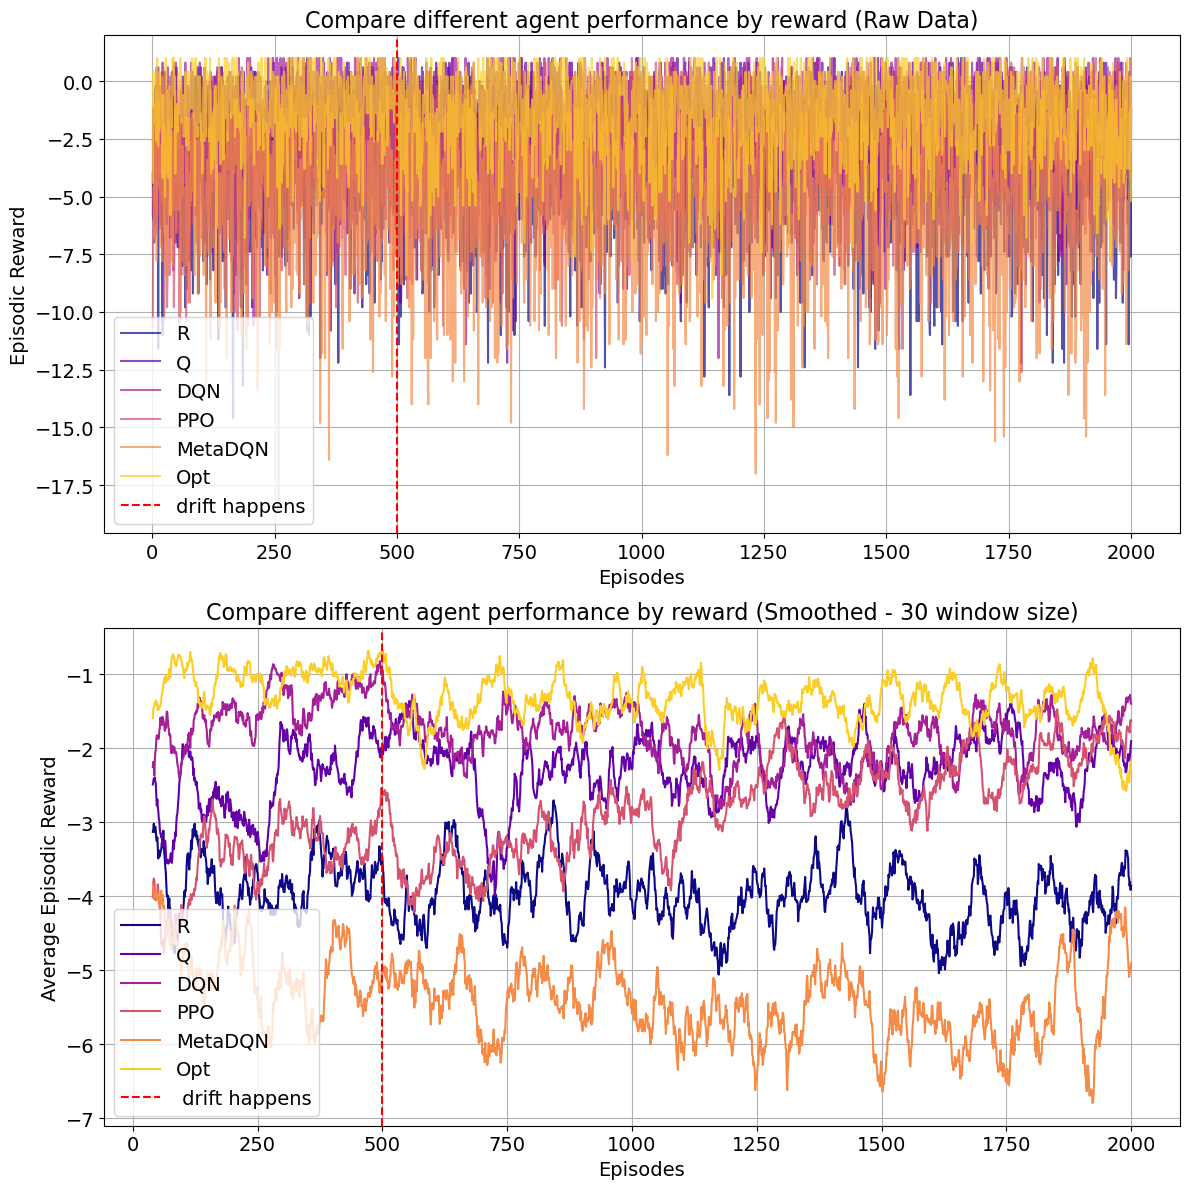

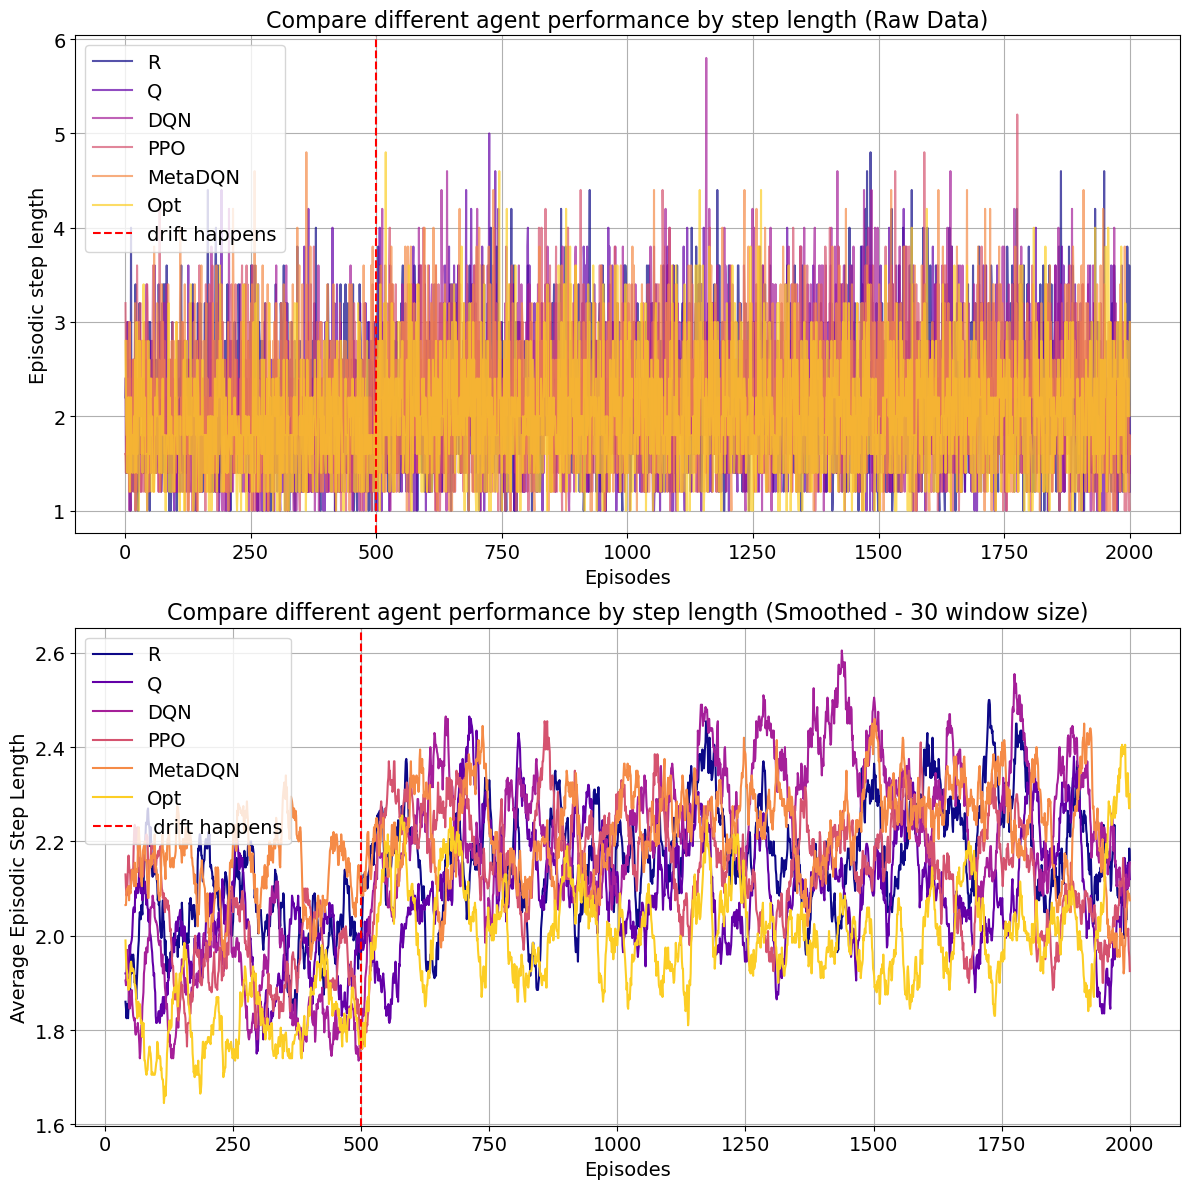

analysis for agent type: Q
std of reward 2.1855899340910225
std of len 0.6489995300460548
the value compute stander, agent post, opt post, agent pre, opt prem, r min: -2.228133333333333 -1.3053684210526315 -2.0820000000000003 -0.9199999999999998 -9.400001
the value compute std, agent post std, opt post std, agent pre std, opt pre std,: 2.16132872300557 1.7410561286797437 2.06341367641101 1.3810141201305655
the alpha value: 0.8629717142722034
analysis for agent type: DQN
std of reward 2.0337607504325574
std of len 0.6905685773332001
the value compute stander, agent post, opt post, agent pre, opt prem, r min: -1.8732000000000002 -1.3053684210526315 -1.042 -0.9199999999999998 -9.400001
the value compute std, agent post std, opt post std, agent pre std, opt pre std,: 2.0566254949957874 1.7410561286797437 1.6378754531404394 1.3810141201305655
the alpha value: 0.9856132092437253
analysis for agent type: PPO
std of reward 2.321923235165194
std of len 0.6511023805823474
the value compute stand

In [65]:
test_all_agents(change_at_state=['pp'], drift_dis_type='similar', drift_type='sudden') #用的保存下来的MDP跑的

Running agent_type=R
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=Q
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=DQN
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=PPO
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=MetaDQN
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Drift applied at episode 500
Running agent_type=Opt
In state va, take action: client toegesproken/gesprek met client
In state sib, take action: geen
In state pp, take action: client toegesp

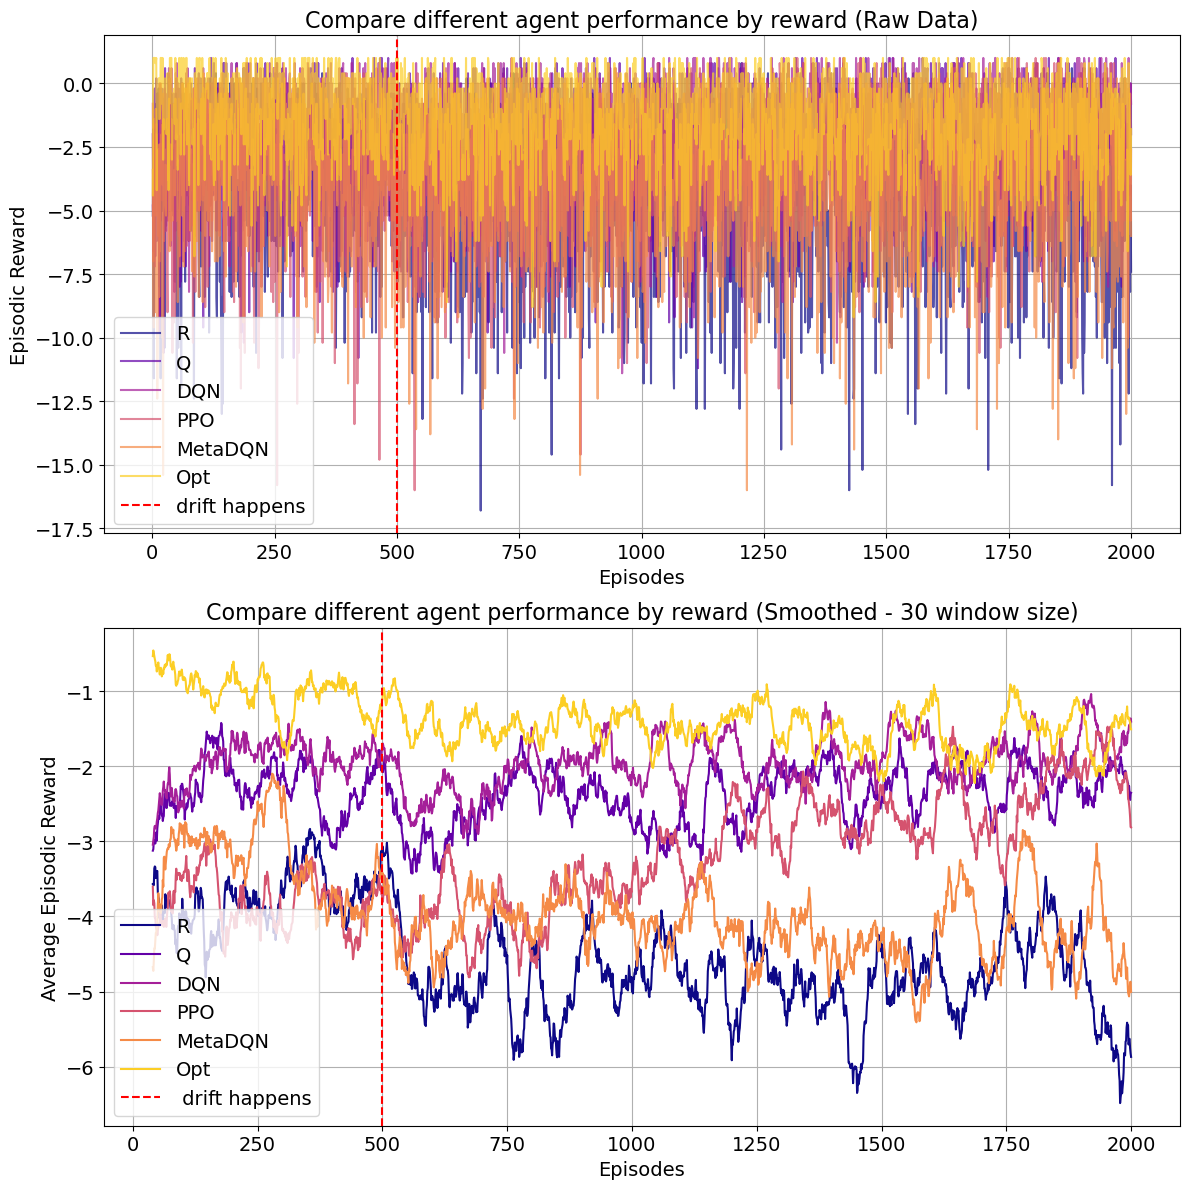

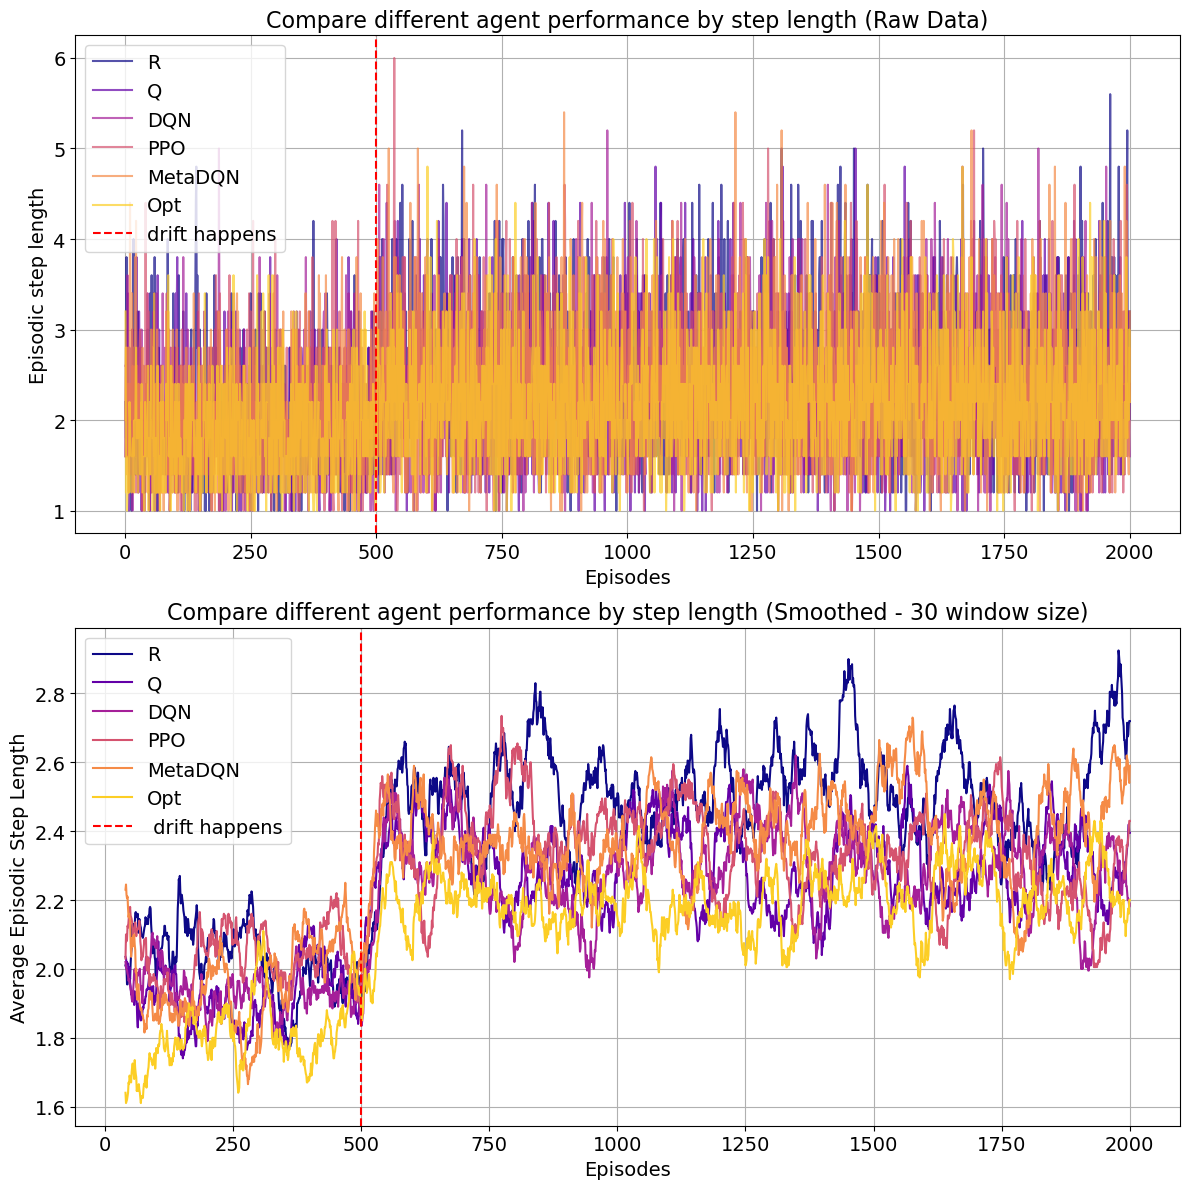

analysis for agent type: Q
std of reward 2.186771682183579
std of len 0.7116598555489835
the value compute stander, agent post, opt post, agent pre, opt prem, r min: -2.4153333333333333 -1.3679999999999999 -2.276 -1.1559999999999997 -10.800001
the value compute std, agent post std, opt post std, agent pre std, opt pre std,: 2.175304933924335 1.7557925785659787 2.1592183770985276 1.363108212872331
the alpha value: 0.8838656279691386
analysis for agent type: DQN
std of reward 2.0198185165999445
std of len 0.7088409624168175
the value compute stander, agent post, opt post, agent pre, opt prem, r min: -1.9557333333333333 -1.3679999999999999 -1.8120000000000003 -1.1559999999999997 -9.200000999999999
the value compute std, agent post std, opt post std, agent pre std, opt pre std,: 2.0087443330487718 1.7557925785659787 1.9794585118157946 1.363108212872331
the alpha value: 0.9184485432062974
analysis for agent type: PPO
std of reward 2.5455666382949005
std of len 0.7150191885537059
the value c

In [40]:
test_all_agents(change_at_state=['pp'], drift_dis_type='inverse', drift_type='sudden') #用的保存下来的MDP跑的

In [73]:
def check_recovery_negative_rewards_gradual(
    opt_pre_drift: List[float],
    agent_pre_drift: List[float],
    opt_post_drift: List[float],
    agent_post_drift: List[float],
    window_size: int = 50,
    consecutive_required: int = 200
):
    # Step 1: 计算 pre-drift 和 post-drift 的平均 reward
    r_opt_pre = np.mean(opt_pre_drift)
    r_agent_pre = np.mean(agent_pre_drift)

    r_opt_std = np.std(opt_pre_drift)
    r_agent_std = np.std(agent_pre_drift)

    
  
    for i in range(0,2):
        r_agent_post = np.mean(agent_post_drift[i])
        r_opt_post = np.mean(opt_post_drift[i])

        # Step 2: 找到合理的 reward 下界，用于归一化
        r_min = min(min(agent_pre_drift), min(opt_pre_drift),
                    min(agent_post_drift[i][:-100]), min(opt_post_drift[i])) - 1 # 避免除以0

        #print("the value compute stander",r_agent_pre, r_opt_pre, r_min)
        # Step 3: 计算 pre-drift agent 的标准表现分数 alpha
        #score_opt_pre = reward_to_score(r_opt_pre, r_opt_pre, r_min)  # 始终为1
        score_agent_pre = reward_to_score(r_agent_pre, r_opt_pre, r_min)
        alpha = score_agent_pre
       # print('the alpha value:', alpha)
        # Step 4: 设定恢复标准（90% of pre-drift performance）
        recovery_threshold = 0.95 * alpha

        # Step 5: 对 post-drift agent 的 reward 做 rolling window
        recovery_streak = 0
        windows_rolled = 0
        recovered = False

        for j in range(len(agent_post_drift[i]) - window_size + 1):
            window = agent_post_drift[i][j : j + window_size]
            window_mean = np.mean(window)
            window_score = reward_to_score(window_mean, r_opt_post, r_min)
            windows_rolled += 1

            if window_score >= recovery_threshold:
                recovery_streak += 1
                if recovery_streak == consecutive_required:
                    recovered = True
                    break
            else:
                recovery_streak = 0

        
        result += (
        "========== RECOVERY EVALUATION ==========\n"
        f'drift time :{i} \n'
        f'r min: {r_min:.2f}\n'
        f"Agent pre-drift average reward: {r_agent_pre:.2f}\n"
        f"Optimal pre-drift average reward: {r_opt_pre:.2f}\n"
        f"Agent post-drift average reward: {r_agent_post:.2f}\n"
        f"Optimal post-drift average reward: {r_opt_post:.2f}\n"
        f"Recovery standard (90% of relative performance): {recovery_threshold:.2f}\n"
        f"Recovered: {recovered}\n"
    )
    
    # 根据是否恢复添加额外信息
    if recovered:
        result += f"Recovery achieved in {windows_rolled} windows\n"
    else:
        result += f"Recovery not achieved in {windows_rolled} windows\n"


    return result



In [74]:

def test_all_agents_gradual(drift_dis_type,drift_type):
    agent_types = ['R', 'Q', 'DQN', 'PPO','MetaDQN','Opt']
    compare_rewards = []
    compare_lengths = []
    std_rewds = []
    std_lens = []

#for compute if the agent recover
    rew_before_drift = [] #per agent
    rewlist_drift = []
    fullrewlist_drift=[]

    for agent_type in agent_types:
        print(f"Running agent_type={agent_type}")
        rewards, lengths = run_agent_avg(agent_type=agent_type, apply_drift=True,drift_dis_type=drift_dis_type,drift_type=drift_type)
        compare_rewards.append(rewards)
        compare_lengths.append(lengths)
        std_rewds.append(np.std(rewards))
        std_lens.append(np.std(lengths))


        rew_before_drift.append(rewards[600:700])
        rewlist_drift.append([rewards[1300:1400],rewards[:-100]])
        fullrewlist_drift.append([rewards[700:1400],rewards[1400:]])


    compare_agents_plot(compare_rewards, agent_types,'reward')
    compare_agents_plot(compare_lengths, agent_types,'length')

    suffix = f"{drift_dis_type}_{drift_type}"
    #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")

    with open(f"{suffix}_output.txt", "a") as f: 
        for i in range(1,6):
            print('analysis for agent type:',agent_types[i])
            print('std of reward', std_rewds[i])
            print('std of len', std_lens[i])
            f.write(f'analysis for agent type: {agent_types[i]}\n')
            f.write(f'std of reward: {std_rewds[i]}\n')
            f.write(f'std of len: {std_lens[i]}\n')
        
        # 调用函数并写入结果
            recovery_result = check_recovery_negative_rewards_gradual(
                rew_before_drift[-1],
                rew_before_drift[i],
                rewlist_drift[-1],
                fullrewlist_drift[i]
            )
            f.write(f'recovery check result: {recovery_result}\n\n')  # 加空行分隔不同 agent 的结果

        """"
        suffix = f"{agent_type}_[pp]_None"
        #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")
        save_to_csv(rewards, f"{suffix}_rewards.csv")
        save_to_csv(lengths, f"{suffix}_lengths.csv")
        save_to_csv([[k, v] for k, v in info.items()], f"{suffix}_info.csv")
               
        df = pd.DataFrame(trojactory)
        df.to_csv(f"./diffagent_res_gradual_random/{suffix}_trojactory.csv", index=True, header=True) 
  
    df = pd.DataFrame([std_rewds, std_lens])
    df.index = ['std_rews', 'std_lens']
    df.to_csv(f"./stdRewLen/stdinverse.csv", index=True, header=True)"""



Running agent_type=R
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=Q
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=DQN
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=PPO
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=MetaDQN
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=Opt
In state va, take action: client toegesproken/gesprek met client
In state sib, take action: geen
In state pp, take action: client toegesp

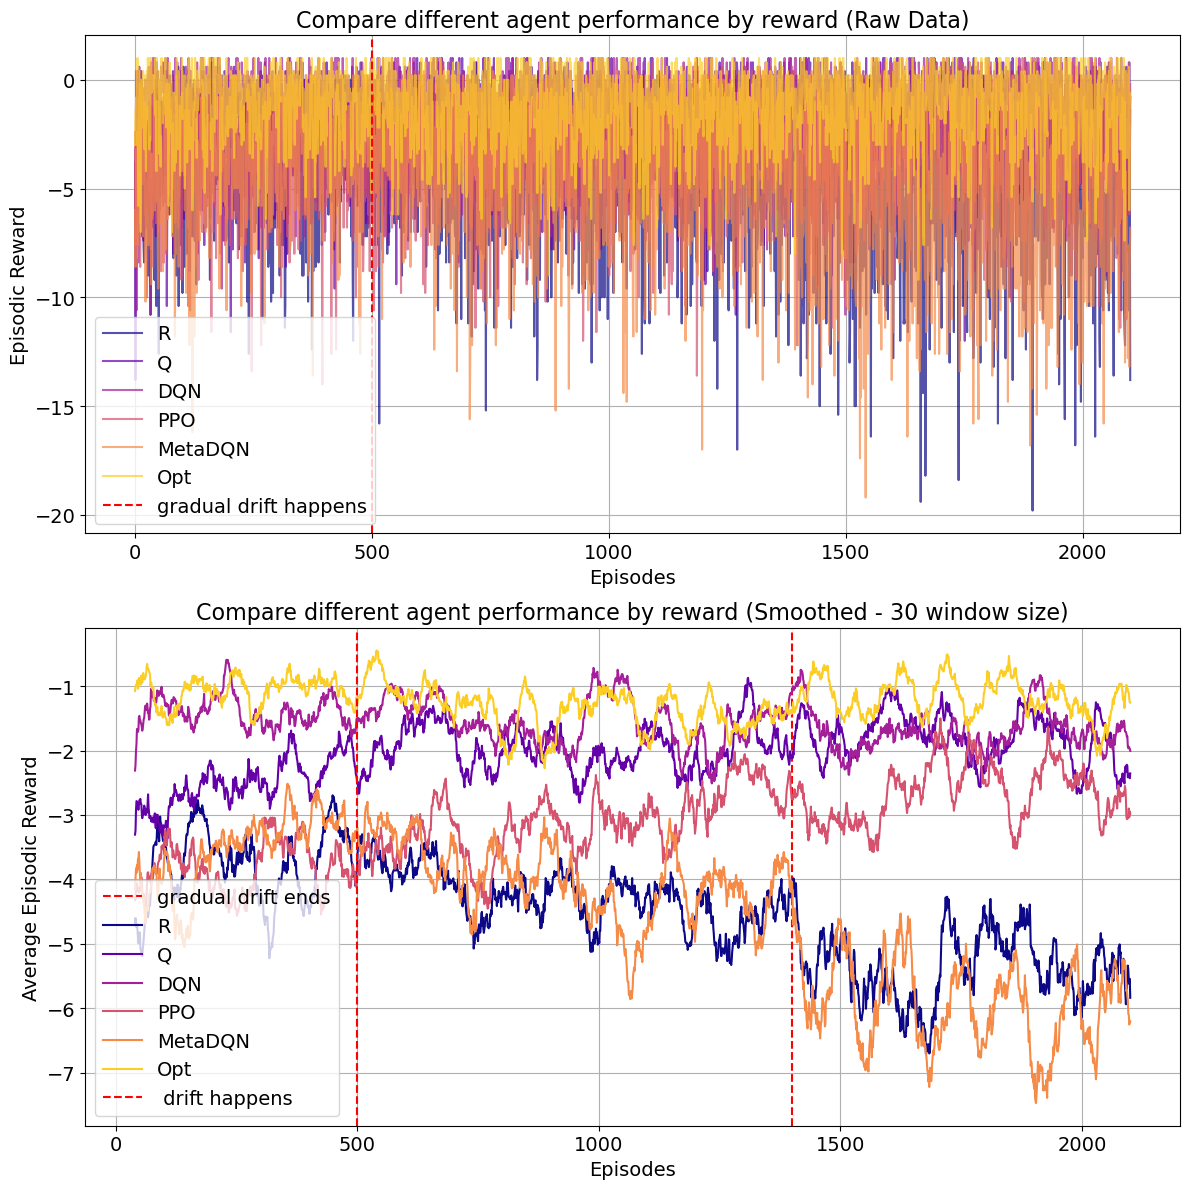

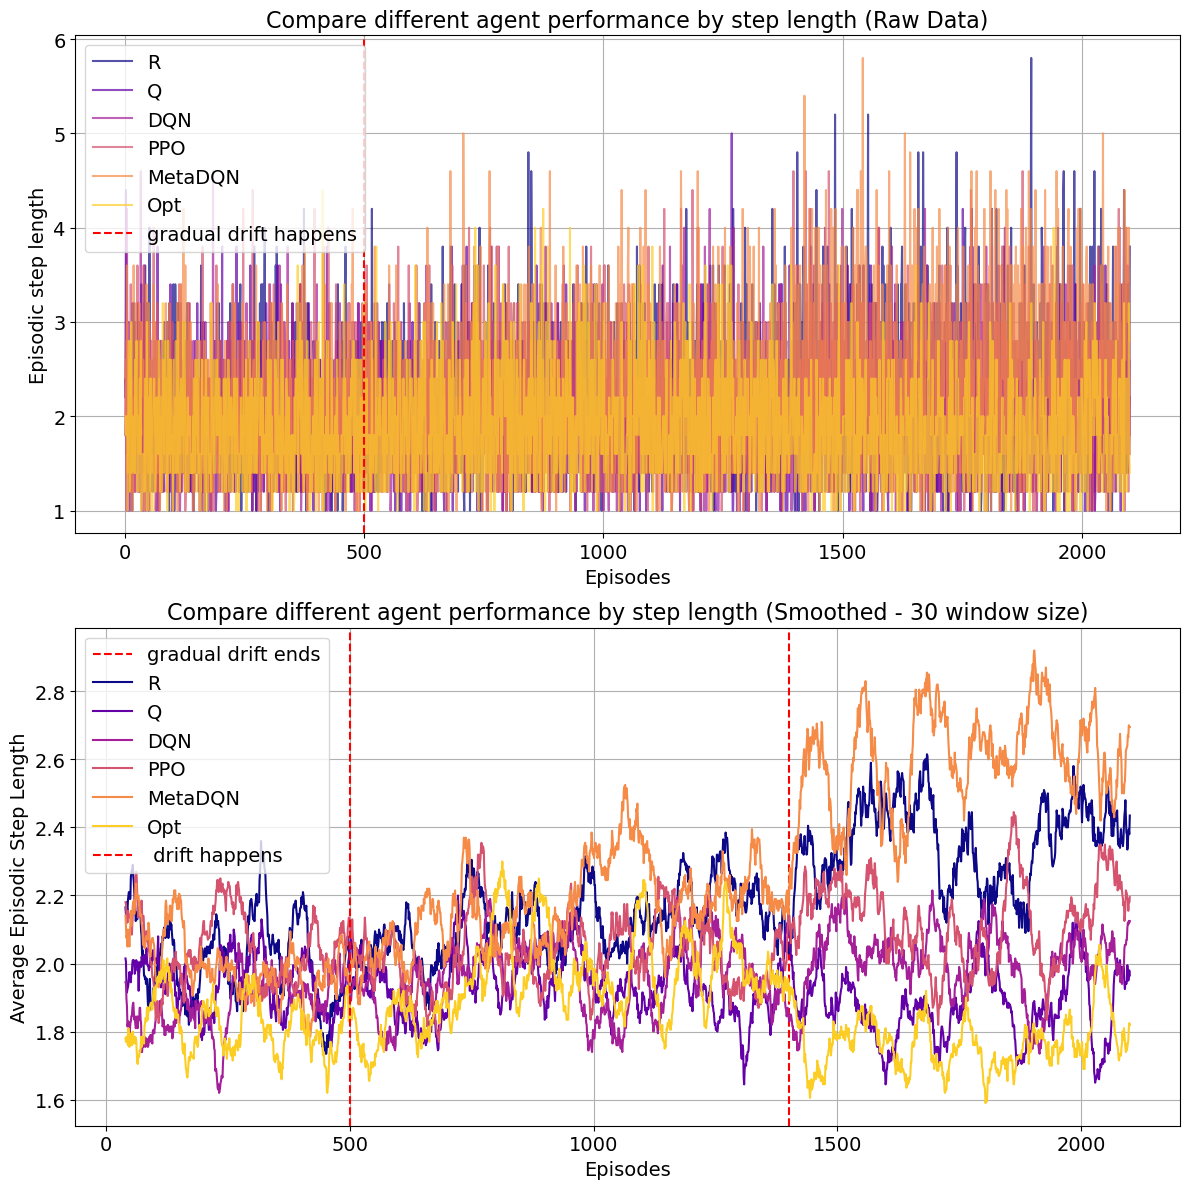

analysis for agent type: Q
std of reward 2.1579807875338184
std of len 0.5835580208675234


UnboundLocalError: cannot access local variable 'result' where it is not associated with a value

In [75]:
test_all_agents_gradual('random','gradual')
test_all_agents_gradual('similar','gradual')
test_all_agents_gradual('inverse','gradual')

In [23]:
#run agent with already generated drifted env
def run_agent_apply_drift(agent_type,apply_drift=True,add_actions=0, change_at_states=['pp'], drift_dis_type='random',intensity = 0.7,drift_type='gradual'):
    #initial agent
    env = TaskEnv_driftype()
    state_dim = len(env.states) 
    action_dim = len(env.motions)  
    state_to_index = {state: idx for idx, state in enumerate(env.states)}
    agent = None
    
    
    match agent_type:
        case 'Q':
            agent = Q_learning_Agent(env)
        case 'DQN':
            agent = DQNAgent(state_dim,action_dim)
        case 'PPO':
            agent = PPOAgent(state_dim,action_dim)
        case 'Opt':
            agent = OptimalPolicyAgent(env)
            agent.value_iteration()
            for state, action in agent.policy.items():
                print(f"In state {state}, take action: {action}")
        case 'R':
            agent = RandomAgent(env)
        case 'MetaDQN':
            agent = MetaDQNAgent(env)
  
    
    episode_rewards = []
    episode_lengths = []
    episodic_trojactory = []
    information = {}


    total_episodes = 2100
    drift_episode = 700 #在第700个episode触发drift

    update_interval=10  #for PPO

    suffix = f"changestate{change_at_states}_{agent_type}"
    for episode in range(total_episodes):
        steps = 0
        # 应用drift
        if apply_drift and episode == drift_episode:             
            env.set_flag()
            #env.drift(add_actions=0, change_at_states=['pp'], drift_dis_type='similar',intensity = 0.7,drift_type='sudden')
            
            env.drift_type=drift_type
            #frequencies = pd.read_csv("./agent_result/agent_result\changestate['pp']_Q_MDP.csv", index_col=0)
            frequencies = pd.read_csv("./agent_result/pp_similar_sud.csv", index_col=0)
           
            for label in frequencies:
                for action in env.motions:
                    frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错
        
            if drift_type=='gradual':
                env.observation_space_drift = frequencies  # 仅改变转移概率
            else:
                env.observation_space = frequencies
        
            """
            print('show original observation space\n')
            print(env.observation_space)
            print('show drifted observatyio n space\n')
            print(env.observation_space_drift)"""

            
            print(f"Drift applied at episode {episode}")
            if agent_type =='Opt':
                print('reset the optimal oplicy for policy iteration model.')
                agent.value_iteration()
                #print('new optimal policy:')
                for state, action in agent.policy.items():
                    print(f"In state {state}, take action: {action}")
                """    
                suffix = f"{agent_type}_{apply_drift}_{change_at_states}_{drift_dis_type}"
                save_to_csv(agent.policy, f"{suffix}_optpolicy.csv")
                """

        if apply_drift and drift_type == 'gradual' and episode == drift_episode+700:
                #swap to another distribution after 100 episode
            env.drift_swap = True
            env.observation_space = env.observation_space_drift.copy(deep=True)
            if agent_type =='Opt':
                print('reset the optimal oplicy for policy iteration model.')
                agent.value_iteration()
                

        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            if agent_type == 'Q':
               # print(agent)
                action = agent.select_action(state)
            elif agent_type in['R','Opt']:
                action = agent.act(state)
            elif agent_type =='DQN':
                action = agent.get_action(state, state_to_index)
            elif agent_type =='PPO':
                action, log_prob, value = agent.select_action(state)
            elif agent_type =='MetaDQN':
                action = agent.act(state)
            
            
            next_state, reward, done, info = env.step(action)
            
            if info != []:
                key = ''.join(str(x) for x in info)
                if key not in information:
                    information[key] = 1
                else:
                    information[key] += 1
            if agent_type == 'Q':
                #print(agentt
                agent.learn(state, action, next_state, reward, done)
            elif agent_type== 'DQN':
                agent.remember(state, action, reward, next_state, done)
                agent.train(batch_size=1, state_to_index=state_to_index)
            elif agent_type =='PPO':
                agent.store_transition(state, action, reward, log_prob, value, done)
            elif agent_type =='MetaDQN':
                agent.remember(state, action, reward, next_state, done)
                # Standard replay
                loss = agent.replay()
                if loss:
                    agent.loss_history.append(loss)
                # Meta-update less frequently
                if episode % 10 == 0:
                    agent.meta_update()
                            # Update target network periodically
                if episode% agent.update_target_every == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                # Decay epsilon
                if agent.epsilon > agent.epsilon_min:
                    agent.epsilon *= agent.epsilon_decay
                  
            state = next_state
            episode_reward += reward
            steps +=1
        if agent_type=='PPO':
            if (episode + 1) % update_interval == 0:
                agent.update()
                agent.clear_memory()
            
        episodic_trojactory.append(info)
        episode_lengths.append(steps)
        episode_rewards.append(episode_reward)
    
    return episode_rewards, episode_lengths,information,episodic_trojactory



def run_agent_avg(agent_type, apply_drift=True, add_actions=0, 
                  change_at_states=['pp'], 
                  drift_dis_type='similar', intensity=0.7, drift_type='sudden'):
    
    num_runs = 5
    all_rewards = []
    all_lengths = []
    info_first_run = None

    for run in range(num_runs):
        rewards, lengths, info, trojactory= run_agent_apply_drift(
            agent_type=agent_type,
            apply_drift=apply_drift,
            add_actions=add_actions,
            change_at_states=change_at_states,
            drift_dis_type=drift_dis_type,
            intensity=intensity,
            drift_type=drift_type
        )
        all_rewards.append(rewards)
        all_lengths.append(lengths)
        if run == 0:
            info_first_run = info
            trojactory_first_run = trojactory

    # Convert to numpy arrays for averaging
    all_rewards = np.array(all_rewards)
    all_lengths = np.array(all_lengths)

    avg_rewards = np.mean(all_rewards, axis=0).tolist()
    avg_lengths = np.mean(all_lengths, axis=0).tolist()

    sd_rewards = np.std(all_rewards, axis=0).tolist()
    sd_lengths = np.std(all_lengths, axis=0).tolist()

    return avg_rewards, avg_lengths, sd_rewards, sd_lengths #info_first_run,trojactory_first_run

In [33]:
test_all_agents_gradual()

TypeError: test_all_agents_gradual() missing 2 required positional arguments: 'drift_dis_type' and 'drift_type'

In [ ]:
def compare_agents_plot_grad(reward_lists, labels,type):
    """
    reward_lists: list of 1D lists or arrays of episodic rewards for each agent
    labels: list of labels for each agent (e.g., ["Random", "Q-Learning", "Value Iteration", "Policy Iteration"])
    """
    def smooth(arr):
        arr = np.array(arr)
        return pd.Series(arr).rolling(window=40).mean()
    
    x = np.arange(1, 2101)  # 100 segments
    colors = cm.plasma(np.linspace(0, 0.9, len(reward_lists)))
    
    # 创建两个子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))  # 总宽度24以容纳两个12宽的图
    
        # 第二个图：不使用smooth
    for rewards, label, color in zip(reward_lists, labels, colors):
        y = rewards
        ax1.plot(x, y, label=label, color=color, alpha=0.7)  # 添加透明度使原始数据更易读
    
    ax1.axvline(x=700, color='red', linestyle='--', label='drift happens')
    ax1.axvline(x=1400, color='red', linestyle='--', label='gradual drift ends')
    if type == 'reward':
        ax1.set_title("Compare different agent performance by reward (Raw Data)")
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Episodic Reward")
    elif type =='length':
        ax1.set_title("Compare different agent performance by step length (Raw Data)")
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Episodic step length")
    ax1.legend()
    ax1.grid(True)
    
    # 第一个图：使用smooth
    for rewards, label, color in zip(reward_lists, labels, colors):
        y = smooth(rewards)
        ax2.plot(x, y, label=label, color=color)
    
    ax2.axvline(x=700, color='red', linestyle='--', label=' drift happens')
    ax2.axvline(x=1400, color='red', linestyle='--', label='gradual drift ends')
    if type == 'reward':
        ax2.set_title("Compare different agent performance by reward (Smoothed - 30 window size)")
        ax2.set_xlabel("Episodes")
        ax2.set_ylabel("Average Episodic Reward")
    if type =='length':
        ax2.set_title("Compare different agent performance by step length (Smoothed - 30 window size)")
        ax2.set_xlabel("Episodes")
        ax2.set_ylabel("Average Episodic Step Length")

    ax2.legend()
    ax2.grid(True)
    
    
    plt.tight_layout()
    plt.show()

In [ ]:
def test_all_agents_grad():
    agent_types = ['R', 'Q', 'DQN', 'PPO','MetaDQN','Opt']
    compare_rewards = []
    compare_lengths = []
    std_rewds = []
    std_lens = []

    for agent_type in agent_types:
        print(f"Running agent_type={agent_type}")
        rewards, lengths, std_rew,std_len = run_agent_avg(agent_type=agent_type, apply_drift=True,drift_dis_type='similar',drift_type='gradual')
        compare_rewards.append(rewards)
        compare_lengths.append(lengths)
        std_rewds.append(std_rew)
        std_lens.append(std_len)
        """"
        suffix = f"{agent_type}_[pp]_None"
        #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")
        save_to_csv(rewards, f"{suffix}_rewards.csv")
        save_to_csv(lengths, f"{suffix}_lengths.csv")
        save_to_csv([[k, v] for k, v in info.items()], f"{suffix}_info.csv")
               
        df = pd.DataFrame(trojactory)
        df.to_csv(f"./diffagent_res_gradual_random/{suffix}_trojactory.csv", index=True, header=True)  """
  
    df = pd.DataFrame([std_rewds, std_lens])
    df.index = ['std_rews', 'std_lens']
    df.to_csv(f"./stdRewLen/gradsim_std.csv", index=True, header=True)

    compare_agents_plot_grad(compare_rewards, agent_types,'reward')
    compare_agents_plot_grad(compare_lengths, agent_types,'length')

Running agent_type=R
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=Q
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=DQN
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=PPO
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=MetaDQN
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Drift applied at episode 700
Running agent_type=Opt
In state va, take action: client toegesproken/gesprek met client
In state sib, take action: geen
In state pp, take action: client toegesp

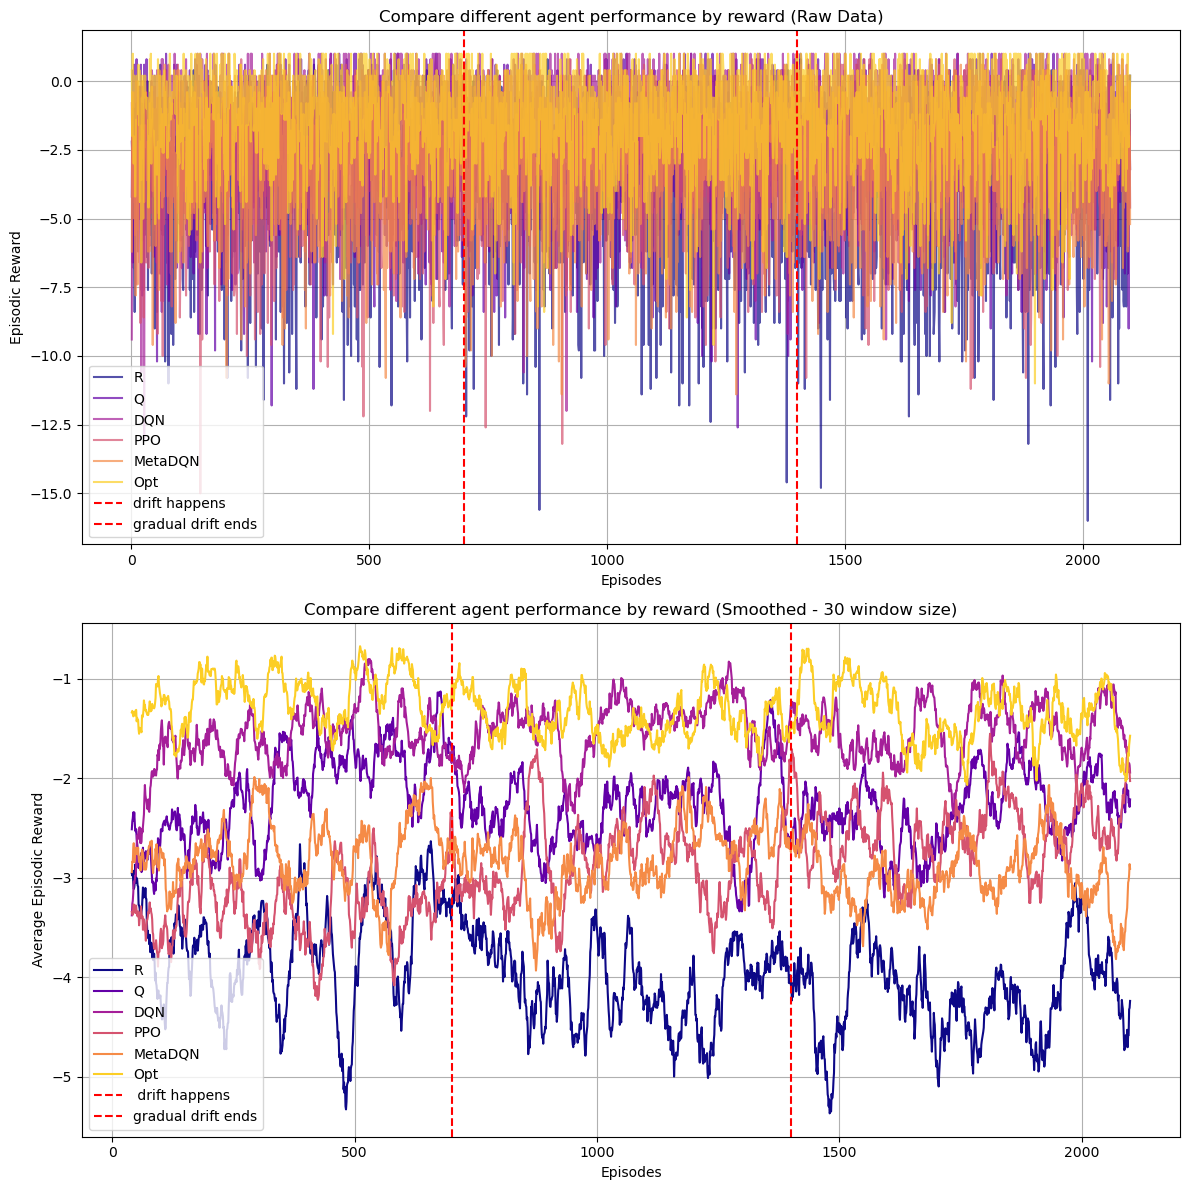

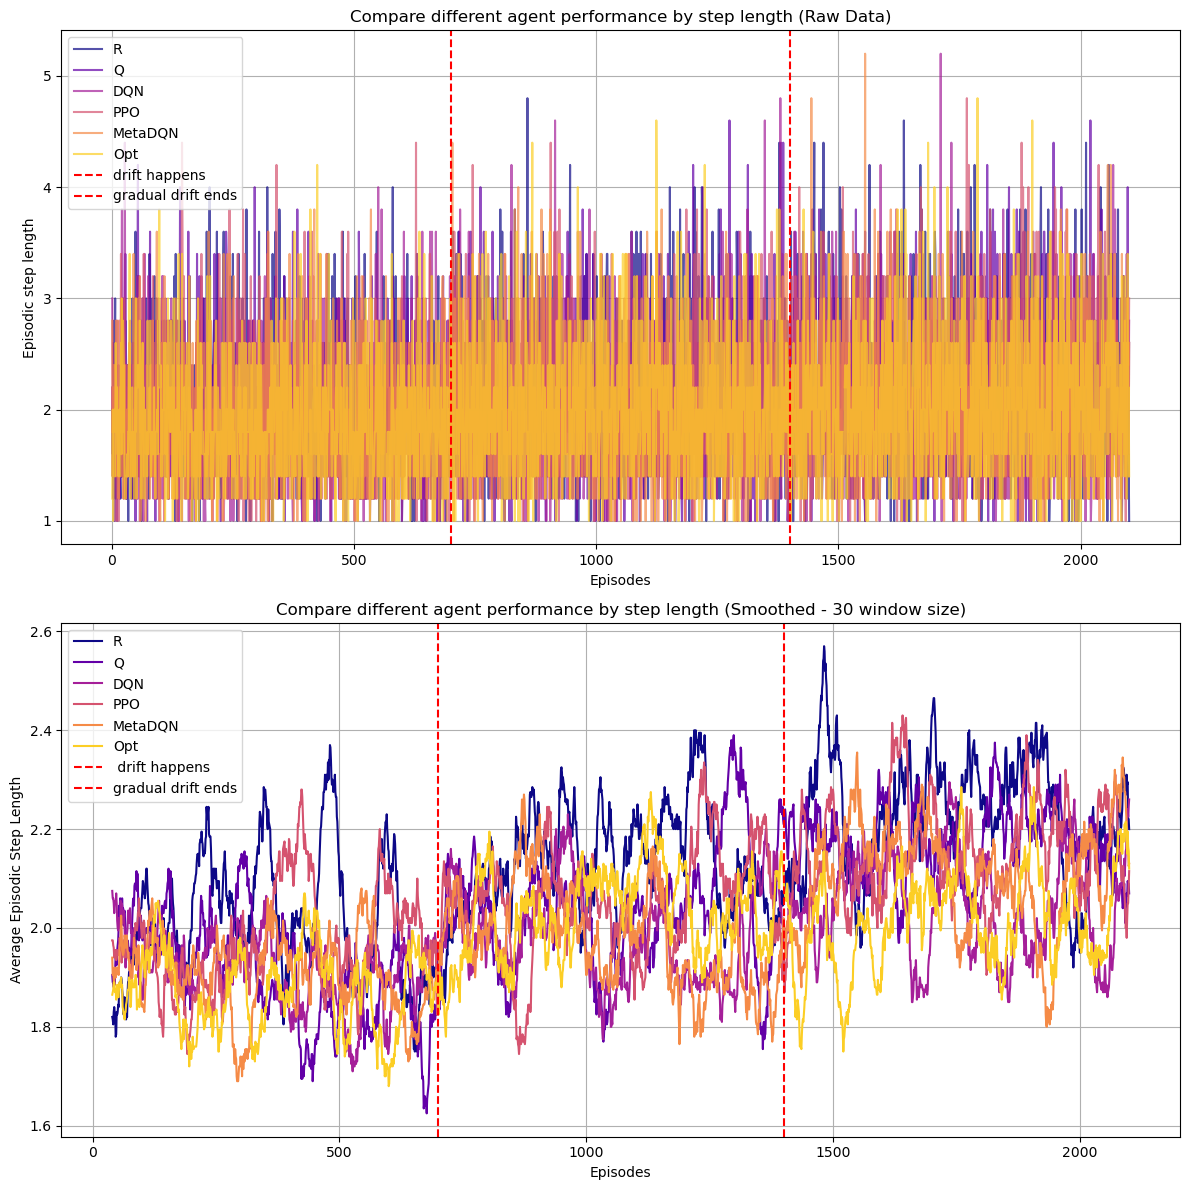

In [ ]:
test_all_agents_grad()

In [49]:
#run agent with already generated drifted env
def run_agent_apply_saved_drift_dis(agent_type,apply_drift=True,add_actions=0, change_at_states=['pp'], drift_dis_type=None,intensity = 0.8,drift_type='sudden'):
    #initial agent
    env = TaskEnv_driftype()
    state_dim = len(env.states) 
    action_dim = len(env.motions)  
    state_to_index = {state: idx for idx, state in enumerate(env.states)}
    agent = None
    
    
    match agent_type:
        case 'Q':
            agent = Q_learning_Agent(env)
        case 'DQN':
            agent = DQNAgent(state_dim,action_dim)
        case 'PPO':
            agent = PPOAgent(state_dim,action_dim)
        case 'Opt':
            agent = OptimalPolicyAgent(env)
            agent.value_iteration()
            for state, action in agent.policy.items():
                print(f"In state {state}, take action: {action}")
        case 'R':
            agent = RandomAgent(env)
        case 'MetaDQN':
            agent = MetaDQNAgent(env)
  
    
    episode_rewards = []
    episode_lengths = []
    episodic_trojactory = []
    information = {}

    total_episodes = 2000
    drift_episode = 500 #在第500个episode触发drift
    update_interval=10  #for PPO

    suffix = f"changestate{change_at_states}_{agent_type}"
    for episode in range(total_episodes):
        steps = 0
        # 应用drift
        if apply_drift and episode == drift_episode:             
            env.set_flag()
            env.drift_type=drift_type
            env.drift(add_actions=0, change_at_states=['pp'], drift_dis_type = drift_dis_type,intensity = intensity,drift_type=drift_type)
            """
            if drift_dis_type=='random':
                frequencies = pd.read_csv("./agent_result/agent_result\changestate['pp']_Q_MDP.csv", index_col=0)
            elif drift_dis_type=='similar':
                frequencies = pd.read_csv("./agent_result/pp_similar_sud.csv", index_col=0)
            elif drift_dis_type=='inverse':
                frequencies = pd.read_csv("./agent_result/pp_inverse_sud.csv", index_col=0)

            for label in frequencies:
                for action in env.motions:
                    frequencies[label][action] = ast.literal_eval(frequencies[label][action]) #判断需要计算的内容是不是合法的Python类型，如果是则执行，否则就报错
          
            if drift_type=='gradual':
                env.observation_space_drift = frequencies  # 仅改变转移概率
            else:
                env.observation_space = frequencies
            """
            
            print(f"Drift applied at episode {episode}")
            if agent_type =='Opt':
                print('reset the optimal oplicy for policy iteration model.')
                agent.value_iteration()

        if apply_drift and drift_type == 'gradual' and episode == drift_episode+700:
                #swap to another distribution after 100 episode
            env.drift_swap = True
            env.observation_space = env.observation_space_drift.copy(deep=True)
            if agent_type =='Opt':
                print('reset the optimal oplicy for policy iteration model.')
                agent.value_iteration()

        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            if agent_type == 'Q':
               # print(agent)
                action = agent.select_action(state)
            elif agent_type in['R','Opt']:
                action = agent.act(state)
            elif agent_type =='DQN':
                action = agent.get_action(state, state_to_index)
            elif agent_type =='PPO':
                action, log_prob, value = agent.select_action(state)
            elif agent_type =='MetaDQN':
                action = agent.act(state)
            
            
            next_state, reward, done, info = env.step(action)
            
            if info != []:
                key = ''.join(str(x) for x in info)
                if key not in information:
                    information[key] = 1
                else:
                    information[key] += 1
            if agent_type == 'Q':
                #print(agentt
                agent.learn(state, action, next_state, reward, done)
            elif agent_type== 'DQN':
                agent.remember(state, action, reward, next_state, done)
                agent.train(batch_size=1, state_to_index=state_to_index)
            elif agent_type =='PPO':
                agent.store_transition(state, action, reward, log_prob, value, done)
            elif agent_type =='MetaDQN':
                agent.remember(state, action, reward, next_state, done)
                # Standard replay
                loss = agent.replay()
                if loss:
                    agent.loss_history.append(loss)
                # Meta-update less frequently
                if episode % 10 == 0:
                    agent.meta_update()
                            # Update target network periodically
                if episode% agent.update_target_every == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                # Decay epsilon
                if agent.epsilon > agent.epsilon_min:
                    agent.epsilon *= agent.epsilon_decay
                  
            state = next_state
            episode_reward += reward
            steps +=1
        if agent_type=='PPO':
            if (episode + 1) % update_interval == 0:
                agent.update()
                agent.clear_memory()
            
        episodic_trojactory.append(info)
        episode_lengths.append(steps)
        episode_rewards.append(episode_reward)
    
    return episode_rewards, episode_lengths,information,episodic_trojactory


In [55]:
#test 3 different dis typ sudden drift on qlearn
def test_agent_driftdis(agent):
    drift_dis_type = ['random','similar','inverse']
    compare_rewards = []
    compare_lengths=[]

    for d in drift_dis_type:
        avg_rew = []
        avg_len = []
        for i in range (3):
        #rewards, lengths, info,trojactory = run_agent_apply_saved_drift_dis(agent_type='Q', apply_drift=True,drift_dis_type=d,drift_type='sudden')
            rewards,lenths,_,_ = run_agent_apply_saved_drift_dis(agent_type=agent, apply_drift=True,drift_dis_type=d,drift_type='sudden')
            avg_rew.append(rewards)
            avg_len.append(lenths)

        compare_rewards.append(np.mean(avg_rew, axis=0).tolist())
        compare_lengths.append(np.mean(avg_len, axis=0).tolist())
        """
        suffix = f"{d}_[pp]_Qlearn"
        #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")
        save_to_csv(rewards, f"{suffix}_rewards.csv")
        save_to_csv(lengths, f"{suffix}_lengths.csv")
        save_to_csv([[k, v] for k, v in info.items()], f"{suffix}_info.csv")
        
               
        df = pd.DataFrame(trojactory)
        df.to_csv(f"./driftdistypeQsud/{suffix}_trojactory.csv", index=True, header=True)  """
    
    compare_agents_plot(compare_rewards, drift_dis_type,'reward')
    compare_agents_plot(compare_lengths, drift_dis_type,'length')

drift happen
change_frequencies function running
Drift applied at episode 500
drift happen
change_frequencies function running
Drift applied at episode 500
drift happen
change_frequencies function running
Drift applied at episode 500
drift happen
change_frequencies function running
Drift applied at episode 500
drift happen
change_frequencies function running
Drift applied at episode 500
drift happen
change_frequencies function running
Drift applied at episode 500
drift happen
change_frequencies function running
Drift applied at episode 500
drift happen
change_frequencies function running
Drift applied at episode 500
drift happen
change_frequencies function running
Drift applied at episode 500


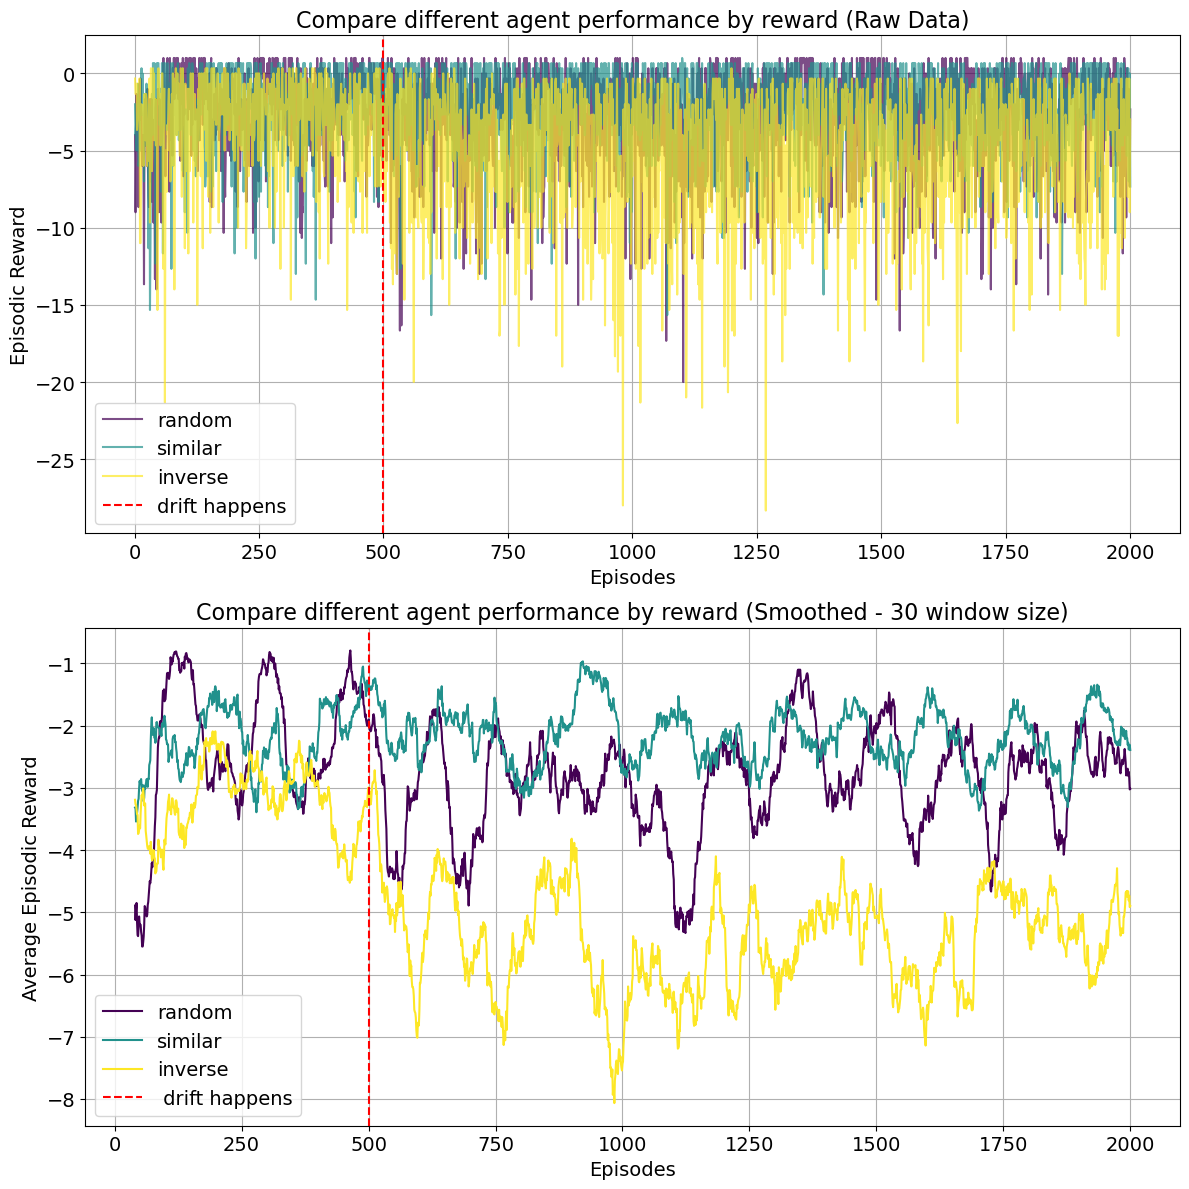

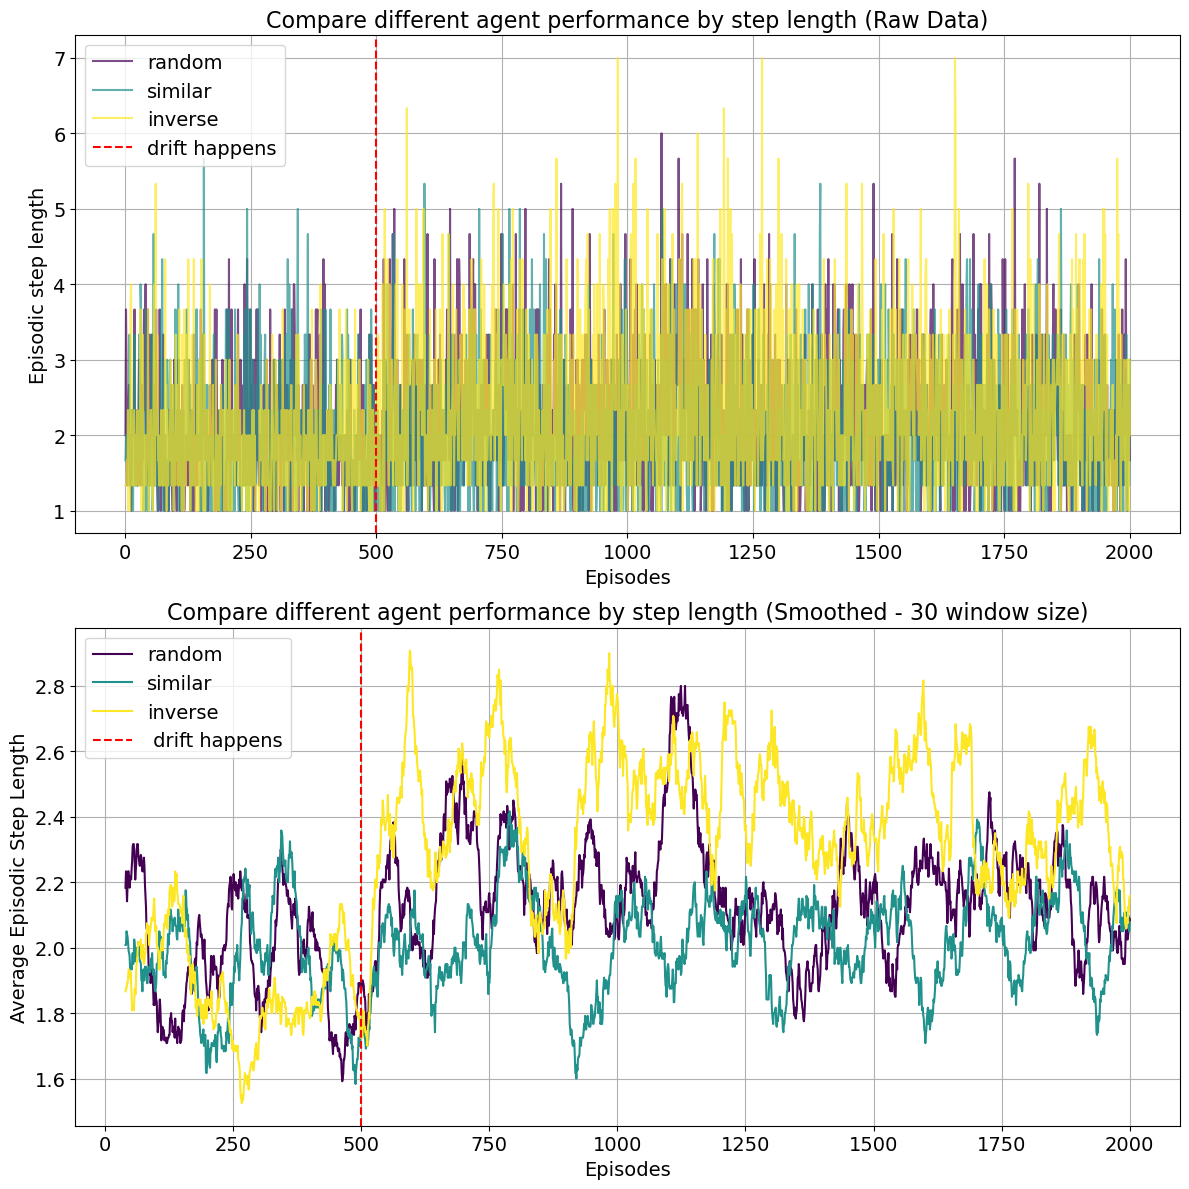

In [57]:
#for a in ['R','Opt','Q','DQN','MetaDQN','PPO']:
for a in ['MetaDQN']:
    test_agent_driftdis(a)

In [49]:
frequencies = pd.read_csv("./agent_result/pp_similar_sud.csv",index_col=0)
frequencies

va  \
contact beeindigd/weggegaan             {'sib': 0.016039481801357187, 'pp': 0.14497223...   
client toegesproken/gesprek met client  {'pp': 0.13498952409458245, 'Tau': 0.574977551...   
geen                                    {'Tau': 0.5918367346938775, 'va': 0.1836734693...   
client afgeleid                         {'pp': 0.17118402282453637, 'Tau': 0.514978601...   
naar andere kamer/ruimte gestuurd       {'Tau': 0.5496974935177182, 'va': 0.2584269662...   
met kracht tegen- of vastgehouden       {'pp': 0.21645021645021645, 'va': 0.1688311688...   
afzondering (deur op slot)              {'pp': 0.4444444444444444, 'sib': 0.0085470085...   

                                                                                      sib  \
contact beeindigd/weggegaan             {'pp': 0.1927710843373494, 'sib': 0.1566265060...   
client toegesproken/gesprek met client  {'Tau': 0.5019206145966709, 'pp': 0.1574903969...   
geen                                    {'va': 0.045512010113780026, 'Tau': 0.56005056...   
client afgeleid                         {'Tau': 0.5410447761194029, 'pp': 0.1604477611...   
naar andere kamer/ruimte gestuurd       {'Tau': 0.5540540540540541, 'pp': 0.2297297297...   
met kracht tegen- of vastgehouden       {'Tau': 0.3983050847457627, 'pp': 0.2330508474...   
afzondering (deur op slot)              {'pp': 0.21052631578947367, 'Tau': 0.526315789...   

                                                                                       pp  \
contact beeindigd/weggegaan             {'pp': 0.2960770059235326, 'Tau': 0.3776386645...   
client toegesproken/gesprek met client  {'va': 0.2903785780240074, 'sib': 0.3884025854...   
geen                                    {'Tau': 0.3605654761904762, 'pp': 0.3085416666...   
client afgeleid                         {'Tau': 0.3718998862343572, 'po': 0.0540045506...   
naar andere kamer/ruimte gestuurd       {'pp': 0.2957087436586094, 'Tau': 0.3834676216...   
met kracht tegen- of vastgehouden       {'Tau': 0.36761693200049367, 'pp': 0.313175367...   
afzondering (deur op slot)              {'va': 0.17417721518987342, 'pp': 0.3058122362...   

                                                                                       po  
contact beeindigd/weggegaan             {'pp': 0.1829787234042553, 'va': 0.14893617021...  
client toegesproken/gesprek met client  {'Tau': 0.5195154777927322, 'pp': 0.2126514131...  
geen                                    {'Tau': 0.5189873417721519, 'sib': 0.075949367...  
client afgeleid                         {'Tau': 0.4915254237288136, 'va': 0.0720338983...  
naar andere kamer/ruimte gestuurd       {'Tau': 0.4945054945054945, 'pp': 0.1978021978...  
met kracht tegen- of vastgehouden       {'Tau': 0.4925373134328358, 'pp': 0.2835820895...  
afzondering (deur op slot)              {'pp': 0.4470588235294118, 'va': 0.14117647058...

In [ ]:
"""
比较四个模型在 sib发生random drift的恢复情况， tau始终保持较大的 prob可到达
"""
def compare_4_models(change_at_states, drift_dis_type,drift_type):
    agent_name = ['Q','R','DQN','Opt']
    reward,length,info = [],[],[]
    
    for a in agent_name:
        r,l,inf = run_agent_avg(a,apply_drift=True,change_at_states=change_at_states,drift_dis_type=drift_dis_type,drift_type=drift_type)
        reward.append(r)
        length.append(l)
        info.append(inf)
    
    compare_agents_plot(reward, agent_name)

compare_4_models(['sib'],'random','gradual')

In [ ]:
"""1. 每个state用q-learn+random跑一次看哪些state上的transition prob变化对最优解的影响大
对比每次drift后 optimal policy的变化
保存变化后的MDP，模型每一个episode的trojactory，每个episode reach terminal state的trojactory 长度

本来就有随机性 所以同样的设定需要重复五次实验取mean
"""
states = ['va','pp','po','sib']
labels = ['nd','va','pp','po','sib']
#labels = ['nd1','nd2','nd3']
def find_impact_state():
    reward,length,info = [],[],[]
    r,l,inf = run_agent_avg('Q',apply_drift=False)
    reward.append(r)
    length.append(l)
    info.append(inf)
    
    for s in states:
        r,l,inf = run_agent_avg('Q',apply_drift=True,add_actions=0, change_at_states=[s], drift_dis_type='random',intensity=0.98)
        reward.append(r)
        length.append(l)
        info.append(inf)
        
    
    compare_agents_plot(reward, labels)

find_impact_state()

In [ ]:
import os
import csv
from itertools import product


# 保存结果到 CSV 文件
def save_to_csv(data, filename):
    os.makedirs("agent_result", exist_ok=True)
    path = os.path.join("agent_result", filename)
    with open(path, mode="w", newline="") as file:
        writer = csv.writer(file)
        if isinstance(data, dict):
            writer.writerow(["State", "Action"])
            for k, v in data.items():
                writer.writerow([k, v])
        elif isinstance(data, list):
            writer.writerow(data)
        else:
            raise ValueError("Unsupported data format for saving.")


# 测试 1：所有 agent_type 在 apply_drift=[False, True] 下都测试
def test_all_agents():
    agent_types = ['R', 'Q', 'DQN', 'Opt']
    compare_rewards = []

    for agent_type in agent_types:
        print(f"Running agent_type={agent_type}")
        rewards, lengths, info,trojactory = run_agent(agent_type=agent_type, apply_drift=True)
        compare_rewards.append(rewards)
        suffix = f"{agent_type}_[pp]_None"
        #save_to_csv(opt_agent.policy, f"{suffix}_optpolicy.csv")
        save_to_csv(rewards, f"{suffix}_rewards.csv")
        save_to_csv(lengths, f"{suffix}_lengths.csv")
        save_to_csv([[k, v] for k, v in info.items()], f"{suffix}_info.csv")
               
        df = pd.DataFrame(trojactory)
        df.to_csv(f"{suffix}_trojactory.csv", index=False, header=False)  
    
    compare_agents_plot(compare_rewards, states)



# 测试 2：Q agent 下，change_at_states ∈ ['sib','va','pp','po'] 且 apply_drift=True
def test_q_agent_drift_states():
    states = ['sib', 'va', 'pp', 'po']
    compare_rewards = []
    for state in states:
        print(f"Running Q agent drift test at state={state}")
        rewards, lengths, info,trojactory = run_agent(
            agent_type='Q',
            apply_drift=True,
            change_at_states=[state],
            drift_dis_type='random',
            intensity=0.5,
            drift_type='sudden'
        )
        compare_rewards.append(rewards)

        suffix = f"findstate_Q_{state}_random"
        save_to_csv(rewards, f"{suffix}_rewards.csv")
        save_to_csv(lengths, f"{suffix}_lengths.csv")
        save_to_csv([[k, v] for k, v in info.items()], f"{suffix}_info.csv")
        df = pd.DataFrame(trojactory)
        df.to_csv(f"{suffix}_trojactory.csv", index=False, header=False)  
    compare_agents_plot(compare_rewards, states)
    return 


In [6]:

# Assuming df is your dataframe
# Convert string dictionaries to actual dictionaries if needed
def MDP_visualization(observation_space):
    df = observation_space.copy(deep=True)

    # Get all components
    actions = df.index.tolist()
    states = df.columns.tolist()
    G = nx.MultiDiGraph()

    # Find all possible states including those in transition probabilities
    all_states = set(states)
    terminal_states = set()

    # First pass to identify all states and terminal states
    for action in actions:
        for current_state in states:
            transitions = df.loc[action, current_state]
            all_states.update(transitions.keys())
            for next_state, prob in transitions.items():
                if next_state == 'Tau' or (isinstance(next_state, str) and next_state.lower().startswith('terminal')):
                    terminal_states.add(next_state)

    # Add nodes
    G.add_nodes_from(states, node_type='state', color='lightblue')
    G.add_nodes_from(terminal_states, node_type='terminal', color='red')

    # Second pass - only keep highest probability transition between any two states
    edge_data = {}
    for action in actions:
        for current_state in states:
            transitions = df.loc[action, current_state]
            for next_state, prob in transitions.items():
                if prob > 0.01:  # Only consider meaningful transitions
                    key = (current_state, next_state)
                    if key not in edge_data or prob > edge_data[key]['probability']:
                        # Shorten action name: first 2 letters + ... + last letter
                        if len(action) > 4:
                            short_action = f"{action[:2]}{action[-1]}"
                        else:
                            short_action = action
                        edge_data[key] = {
                            'action': action,
                            'short_action': short_action,
                            'probability': prob,
                            'label': f"{short_action}\n{prob:.2f}"
                        }


    # Add edges to graph
    for (u, v), data in edge_data.items():
        G.add_edge(u, v, **data)

    # Create figure with hierarchical layout
    plt.figure(figsize=(16, 12))
    ax = plt.gca()

    # Use multipartite layout for better organization
    pos = nx.multipartite_layout(G, subset_key='node_type', align='horizontal')

    # Adjust y-position of terminal states to be at the bottom
    if terminal_states:
        min_y = min(y for (x, y) in pos.values())
        for node in terminal_states:
            pos[node] = (pos[node][0], min_y - 0.2)

    # Draw state nodes
    state_nodes = [n for n in G.nodes if n not in terminal_states]
    terminal_nodes = [n for n in G.nodes if n in terminal_states]

    # Draw nodes with different styles
    nx.draw_networkx_nodes(G, pos, nodelist=state_nodes, 
                        node_color='lightblue', 
                        node_size=3000,
                        node_shape='s',
                        edgecolors='black',
                        linewidths=2)

    nx.draw_networkx_nodes(G, pos, nodelist=terminal_nodes, 
                        node_color='red', 
                        node_size=3000,
                        node_shape='s',
                        edgecolors='black',
                        linewidths=2)

    # Draw state labels (with white background for readability)
    state_labels = {node: node for node in G.nodes}
    text_items = nx.draw_networkx_labels(G, pos, labels=state_labels, 
                                    font_size=12, 
                                    font_weight='bold')
    for _, text in text_items.items():
        text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Draw edges with curved arrows and labels
    for (u, v, d) in G.edges(data=True):
        # Calculate curvature - more curve for transitions to same state
        rad = 0.1 if u != v else 0.5
        
        # Draw curved arrow
        arrow = FancyArrowPatch(pos[u], pos[v],
                            arrowstyle='->',
                            connectionstyle=f'arc3,rad={rad}',
                            color='black',
                            linewidth=1 + 3*d['probability'],  # Thicker for higher prob
                            alpha=0.8,
                            mutation_scale=40)
        ax.add_patch(arrow)
        
        # Position label at 1/3 point of the arrow
        label_pos_x = pos[u][0] + (pos[v][0] - pos[u][0]) * 0.33
        label_pos_y = pos[u][1] + (pos[v][1] - pos[u][1]) * 0.33
        
        # Adjust label position to avoid overlap
        offset_dir = np.array([pos[v][1] - pos[u][1], pos[u][0] - pos[v][0]])
        if np.linalg.norm(offset_dir) > 0:
            offset_dir = offset_dir / np.linalg.norm(offset_dir) * 0.05
        
        plt.text((label_pos_x + offset_dir[1])/0.95, 
                (label_pos_y + offset_dir[0])/0.95,
                d['label'],
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.2'),
                fontsize=10, ha='center', va='center')

    # Add title and legend
    plt.title("MDP State Transition Diagram\n(Arrows show highest probability transitions)", 
            fontsize=14, pad=20)

    # Create custom legend
    legend_elements = [
        Patch(facecolor='lightblue', edgecolor='black', label='States'),
        Patch(facecolor='red', edgecolor='black', label='Terminal States'),
        Line2D([0], [0], color='black', lw=3, label='Transition (thickness = probability)'),
        Line2D([0], [0], marker='>', color='w', label='Action (shortened) → Probability',
            markerfacecolor='black', markersize=10)
    ]

    plt.legend(handles=legend_elements, loc='lower left', fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

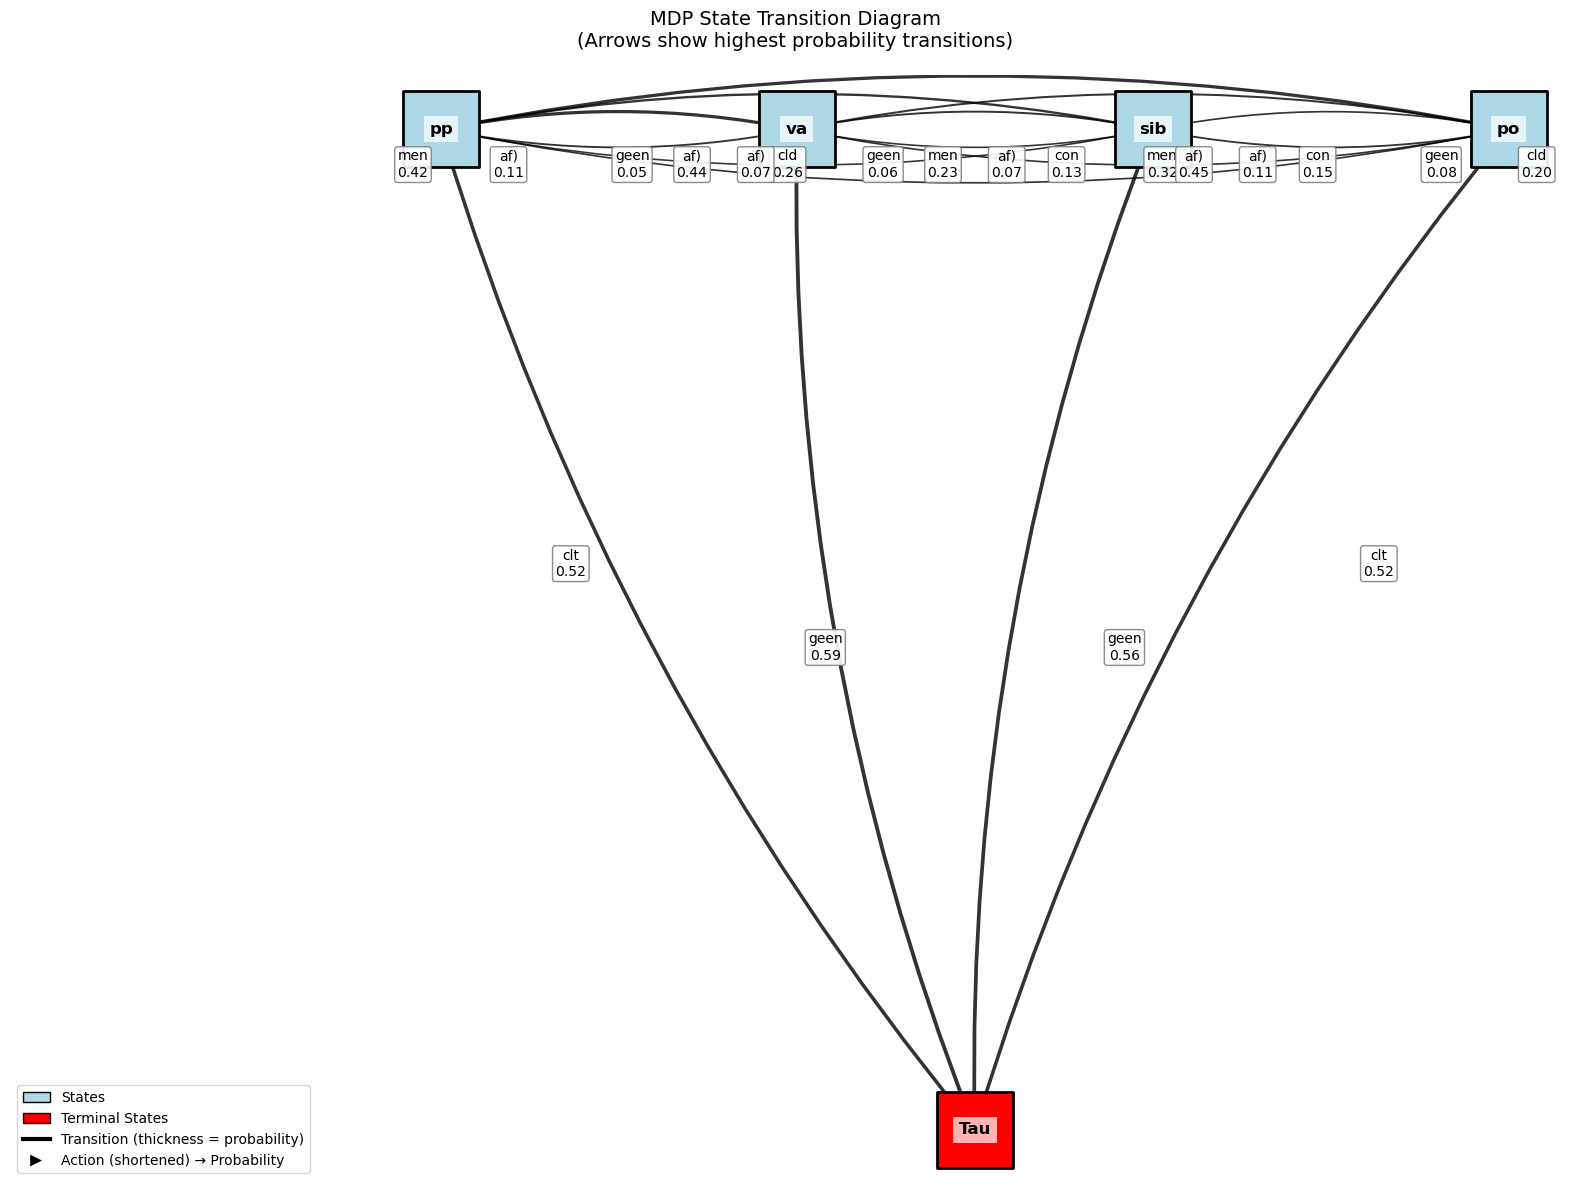

In [7]:
MDP_visualization(env_visual.observation_space)

In [11]:
def build_mdp_graph(P):
    """
    根据 transition probability 构建一个有向图
    P: transition 字典 P[s][a][s'] = prob
    """
    df = P.copy(deep=True)

    # Get all components
    actions = df.index.tolist()
    states = df.columns.tolist()
    G = nx.MultiDiGraph()

    # Find all possible states including those in transition probabilities
    all_states = set(states)
    terminal_states = set()

    # First pass to identify all states and terminal states
    for action in actions:
        for current_state in states:
            transitions = df.loc[action, current_state]
            all_states.update(transitions.keys())
            for next_state, prob in transitions.items():
                if next_state == 'Tau' or (isinstance(next_state, str) and next_state.lower().startswith('terminal')):
                    terminal_states.add(next_state)

    # Add nodes
    G.add_nodes_from(states, node_type='state', color='lightblue')
    G.add_nodes_from(terminal_states, node_type='terminal', color='red')

    # Second pass - only keep highest probability transition between any two states
    edge_data = {}
    for action in actions:
        for current_state in states:
            transitions = df.loc[action, current_state]
            for next_state, prob in transitions.items():
                if prob > 0.01:  # Only consider meaningful transitions
                    key = (current_state, next_state)
                    if key not in edge_data or prob > edge_data[key]['probability']:
                        # Shorten action name: first 2 letters + ... + last letter
                        if len(action) > 4:
                            short_action = f"{action[:2]}{action[-1]}"
                        else:
                            short_action = action
                        edge_data[key] = {
                            'action': action,
                            'short_action': short_action,
                            'probability': prob,
                            'label': f"{short_action}\n{prob:.2f}"
                        }


    # Add edges to graph
    for (u, v), data in edge_data.items():
        G.add_edge(u, v, **data)
    return G

In [12]:
G = build_mdp_graph(env_visual.observation_space)

# 1. Degree Centrality
degree_centrality = nx.out_degree_centrality(G)

# 2. Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# 3. Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)


In [16]:
degree_centrality, betweenness_centrality, closeness_centrality

({'va': 1.25, 'sib': 1.25, 'pp': 1.25, 'po': 1.25, 'Tau': 0.0},
 {'va': 0.0, 'sib': 0.0, 'pp': 0.0, 'po': 0.0, 'Tau': 0.0},
 {'va': 0.75, 'sib': 0.75, 'pp': 0.75, 'po': 0.75, 'Tau': 1.0})